# Model-map illustration of results

## Introduction

In this demo, we illustrate the use of the model-map illustration of result objects. This illustrates the same results as `rsatoolbox.vis.plot_model_comparison` in a different format. The method places the data-RDM at the center and the models around it such that being close to the data represets high model performance. The placement around the circle is then used to represent the dissimilarities between models.

To create this plot the overall method internally runs the following steps:
1. Extract the model-performances, error-bars and significance tests
2. Compute model similarites
3. Show the model similarity matrix
4. Embed the models using MDS (using `weighted_MDS` or `custom_MDS`)
5. Plot the Shepard plot for the embedding (using `show_Shepard_plot`)
6. Make the first plot (using `plot_model_map_elastic`)
7. Make the second plot (using `plot_model_map`)

The named individual steps can be run separately, but for standard use running `map_model_comparison` which performs all steps coherently should be sufficient. 

### Computing some results
To have something to plot, we first regenerate the analyses from the bootstrapping demo (demo_bootstrap).

Standard imports:

In [ ]:
import numpy as np
from scipy import io
import rsatoolbox

Generating models:

In [2]:
matlab_data = io.matlab.loadmat('rdms_inferring/modelRDMs_A2020.mat')
matlab_data = matlab_data['modelRDMs']
n_models = len(matlab_data[0])
model_names = [matlab_data[0][i][0][0] for i in range(n_models)]
measurement_model = [matlab_data[0][i][1][0] for i in range(n_models)]
rdms_array = np.array([matlab_data[0][i][3][0] for i in range(n_models)])
model_rdms = rsatoolbox.rdm.RDMs(rdms_array,
                            rdm_descriptors={'brain_computational_model':model_names,
                                             'measurement_model':measurement_model},
                            dissimilarity_measure='Euclidean'
                           )
matlab_data = io.matlab.loadmat('rdms_inferring/noisyModelRDMs_A2020.mat')
repr_names_matlab = matlab_data['reprNames']
fwhms_matlab = matlab_data['FWHMs']
noise_std_matlab = matlab_data['relNoiseStds']
rdms_matlab = matlab_data['noisyModelRDMs']
repr_names = [repr_names_matlab[i][0][0] for i in range(repr_names_matlab.shape[0])]
fwhms = fwhms_matlab.squeeze().astype('float')
noise_std = noise_std_matlab.squeeze().astype('float')
rdms_matrix = rdms_matlab.squeeze().astype('float')

i_rep = 2 #np.random.randint(len(repr_names)) 
i_noise = 1 #np.random.randint(len(noise_std))
i_fwhm = 0 #np.random.randint(len(fwhms))

rdms_data = rsatoolbox.rdm.RDMs(rdms_matrix[:, i_rep, i_fwhm, i_noise, :].transpose())
models = []
for i_model in np.unique(model_names):
    rdm_m = model_rdms.subset('brain_computational_model', i_model).subset('measurement_model','complete')
    m = rsatoolbox.model.ModelFixed(i_model, rdm_m)
    models.append(m)
models_flex = []
for i_model in np.unique(model_names):
    models_flex.append(rsatoolbox.model.ModelSelect(i_model,
        model_rdms.subset('brain_computational_model', i_model)))

Computing results (Fixed model analysis, crossvalidation, and bootstrap-crossvalidation):

In [3]:
# This may take a short while
results_1 = rsatoolbox.inference.eval_fixed(models, rdms_data, method='corr')
train_set, test_set, ceil_set = rsatoolbox.inference.sets_k_fold(rdms_data, k_pattern=3, k_rdm=2)
results_2_cv = rsatoolbox.inference.crossval(models_flex, rdms_data, train_set, test_set,
                                             ceil_set=ceil_set, method='corr')
results_3_full = rsatoolbox.inference.bootstrap_crossval(models_flex, rdms_data, k_pattern=4, k_rdm=2, method='corr', N=100)



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.89it/s]


# Plotting results
We can now use the function `rsatoolbox.vis.map_model_comparison` to illustrate these results. Each run of the function starts with a summary description of which statistical inferences were performed. Then three plots are produced:
1. A distance matrix for the models, i.e. how far the individual models are from each other.
2. A Shepard plot, plotting the displayed distances against the true distances in the high dimensional model-RDM space.
3. An elastic plot, which draws the models in the MDS embedding and adds connections that indicate by their color and thickness whether the shown distance is smaller or larger than the distance in the high-dimensional model-RDM space.
4. The model map plot with an indication for the Tests between models and the data, i.e. showing the model comparison corrected tests which models performed differently well. 

These plots can in principle be invoked separately, but we generally recommend running the whole procedure to get a full picture.

In the following we show these plots for all three examples we just computed:

Model comparisons: two-tailed, FDR q < 0.01 (36 model-pair comparisons)
Error bars indicate the standard error of the mean.
One-sided comparisons of each model performance against 0 and against the lower-bound estimate of the noise ceiling are Bonferroni-corrected for 9 models.
Inter-RDM distances were measured by the Pearson correlation distance (proportional to squared Euclidean distance after RDM centering and divisive normalization).Inter-RDM distances are mapped as Euclidean distance (proportional to the square root of correlation or cosine distance if RDMs were appropriately normalized).

Formula-based average distance: 0.9194


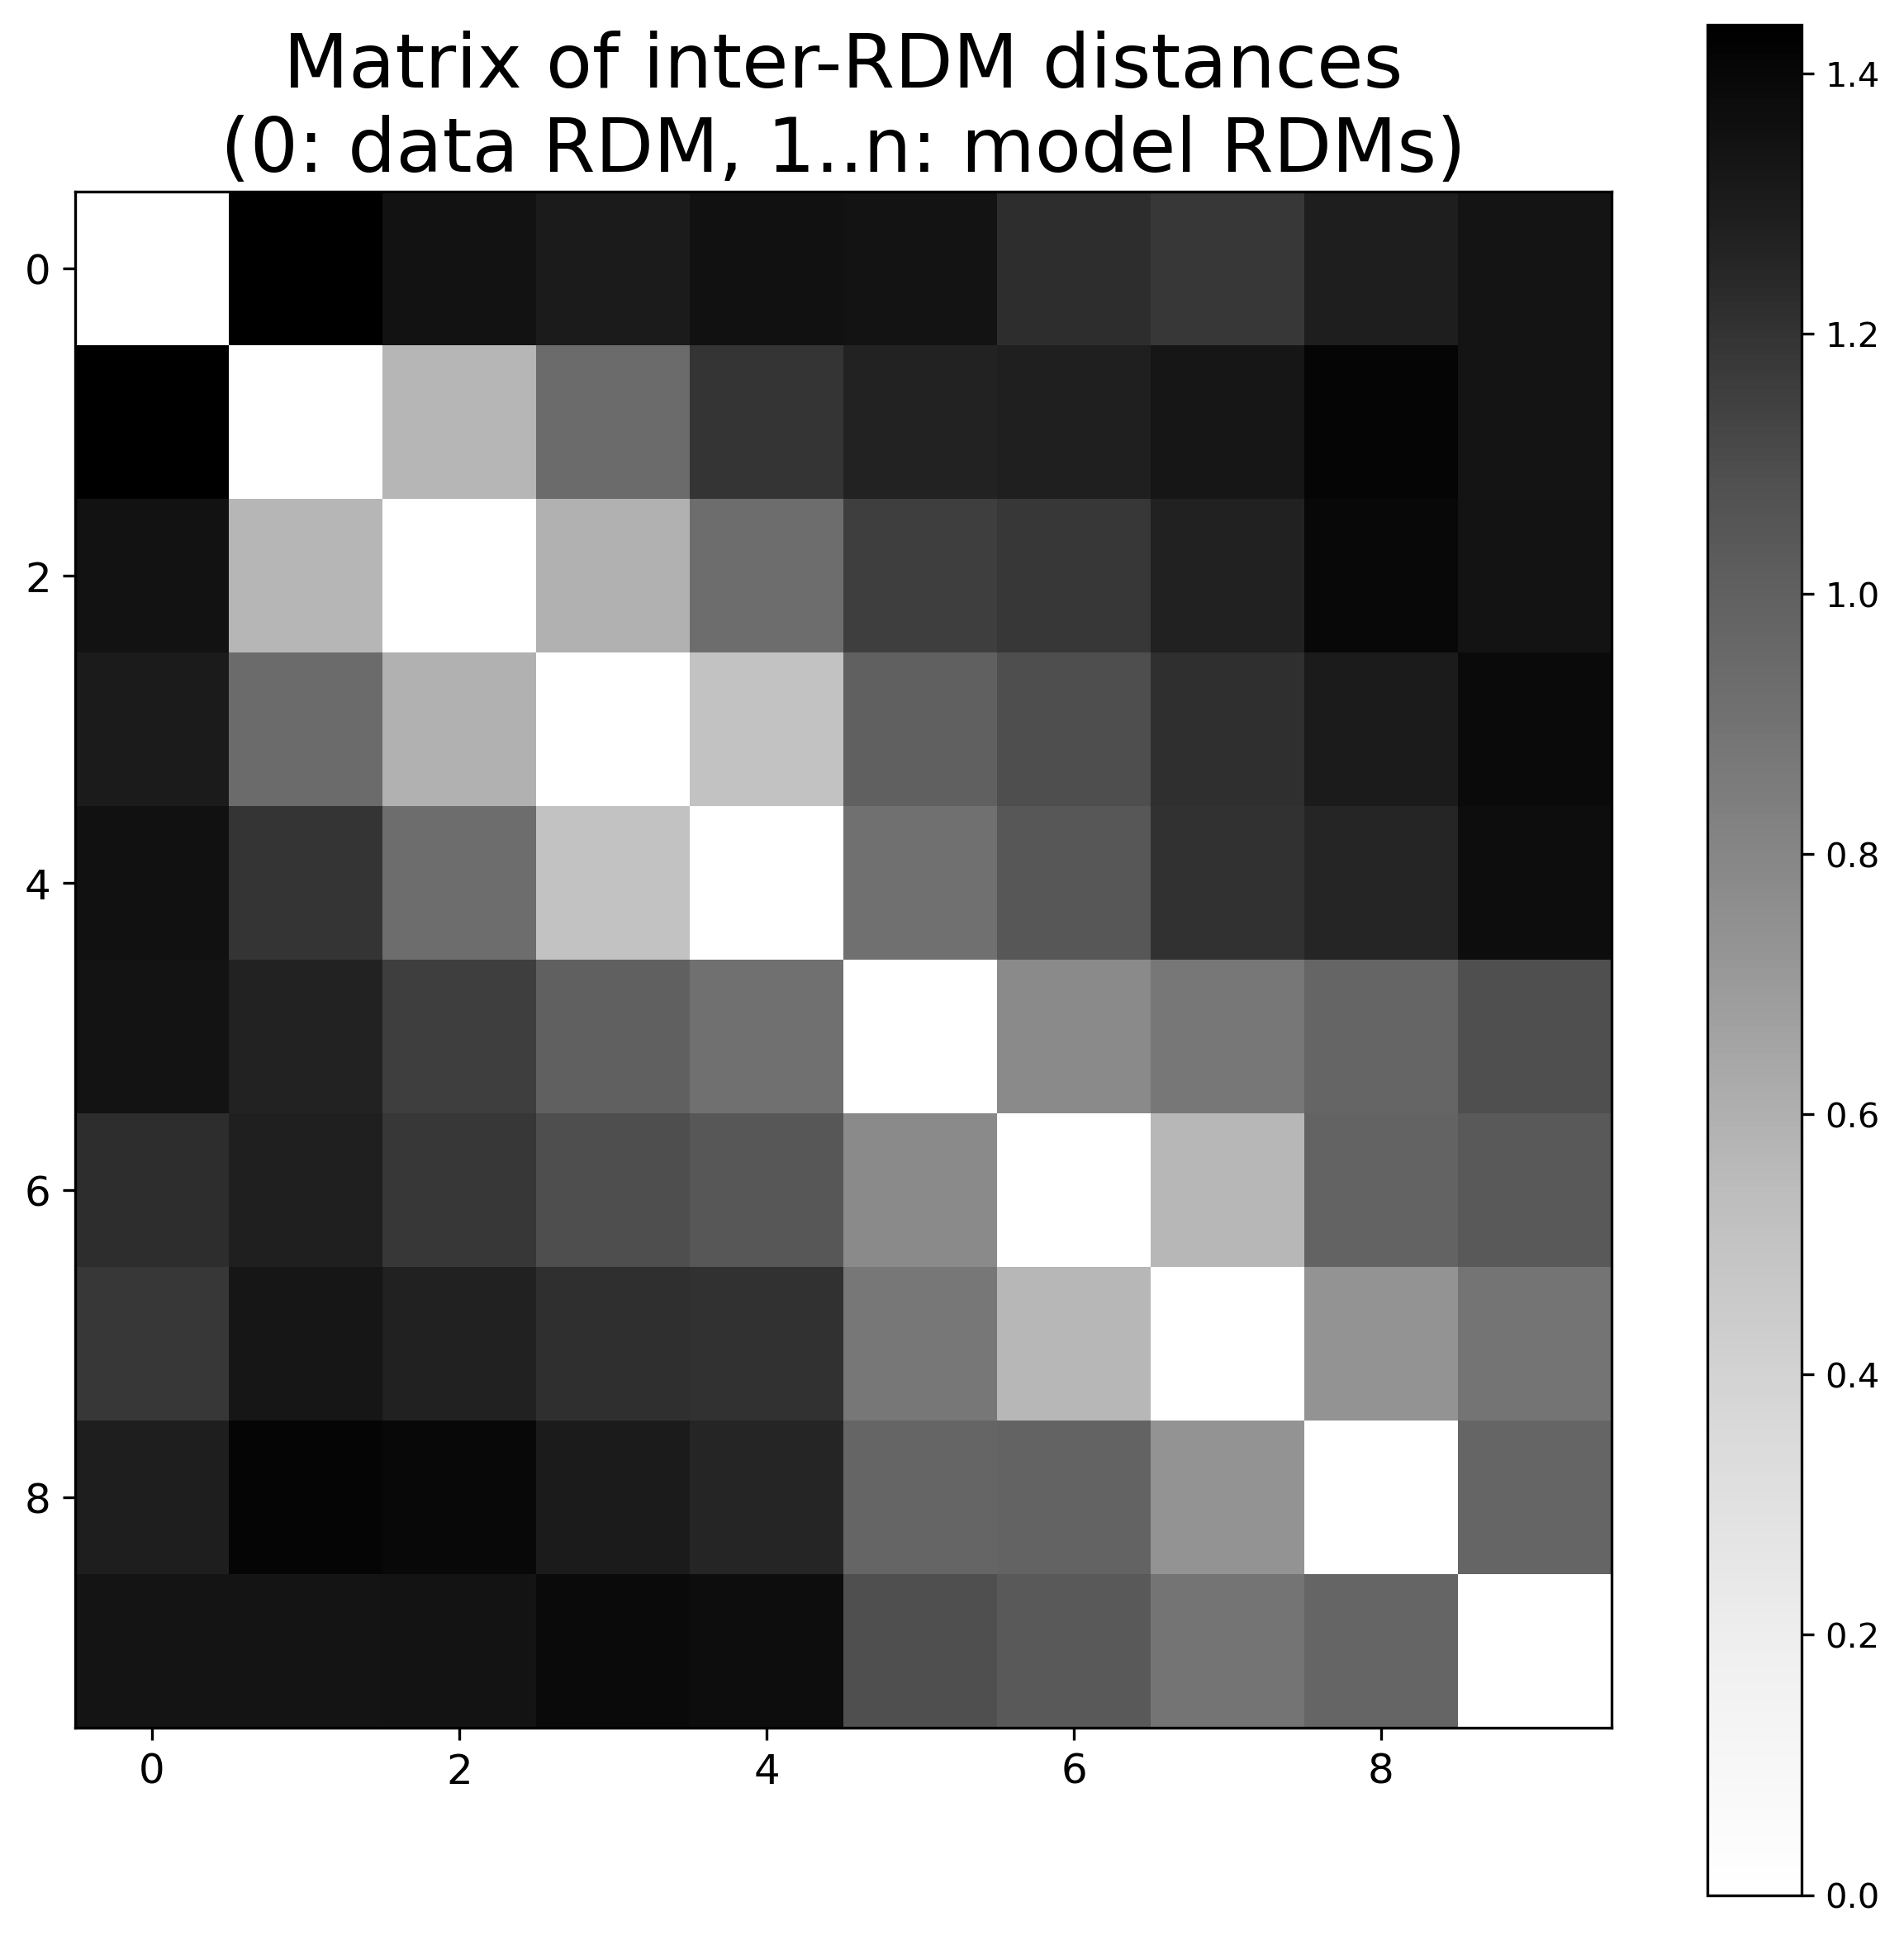

(10, 10)
Pearson r(RDM dist, 2d-map dist): 0.9104
Pearson r(RDM dist, 2d-map dist) for model-data dists: 1.0000
Spearman r(RDM dist, 2d-map dist) for model-data dists: 1.0000


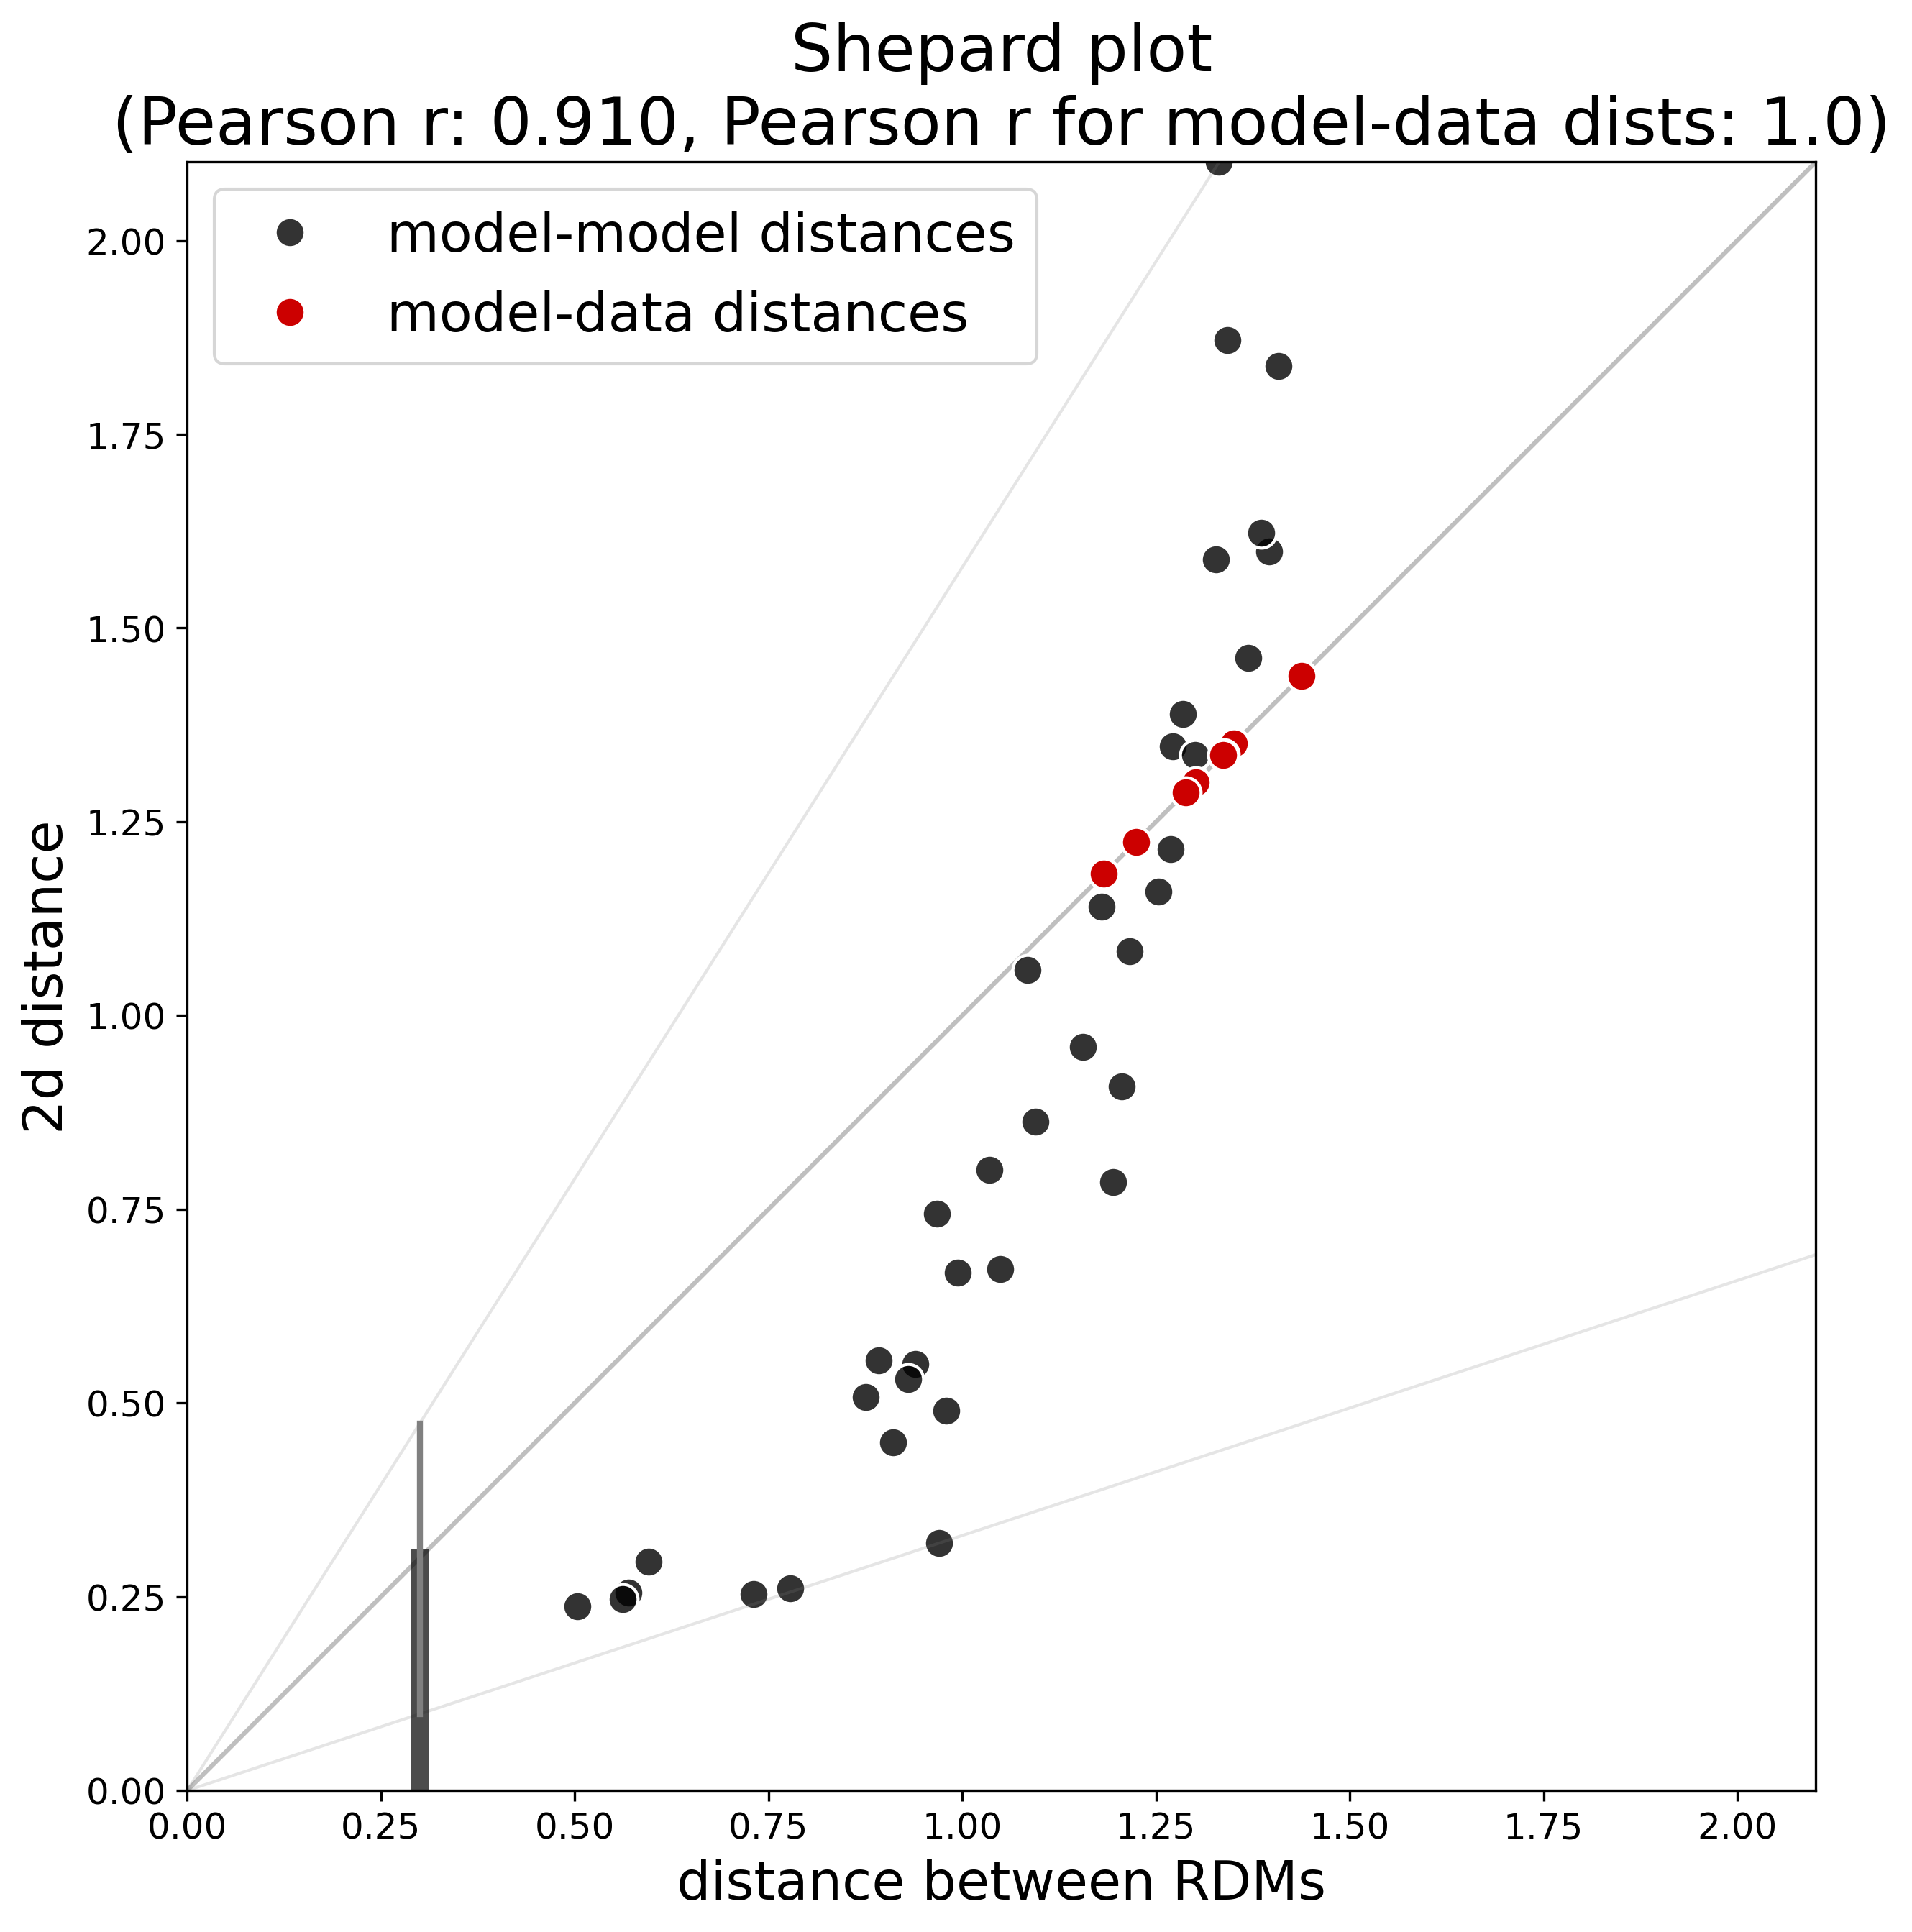

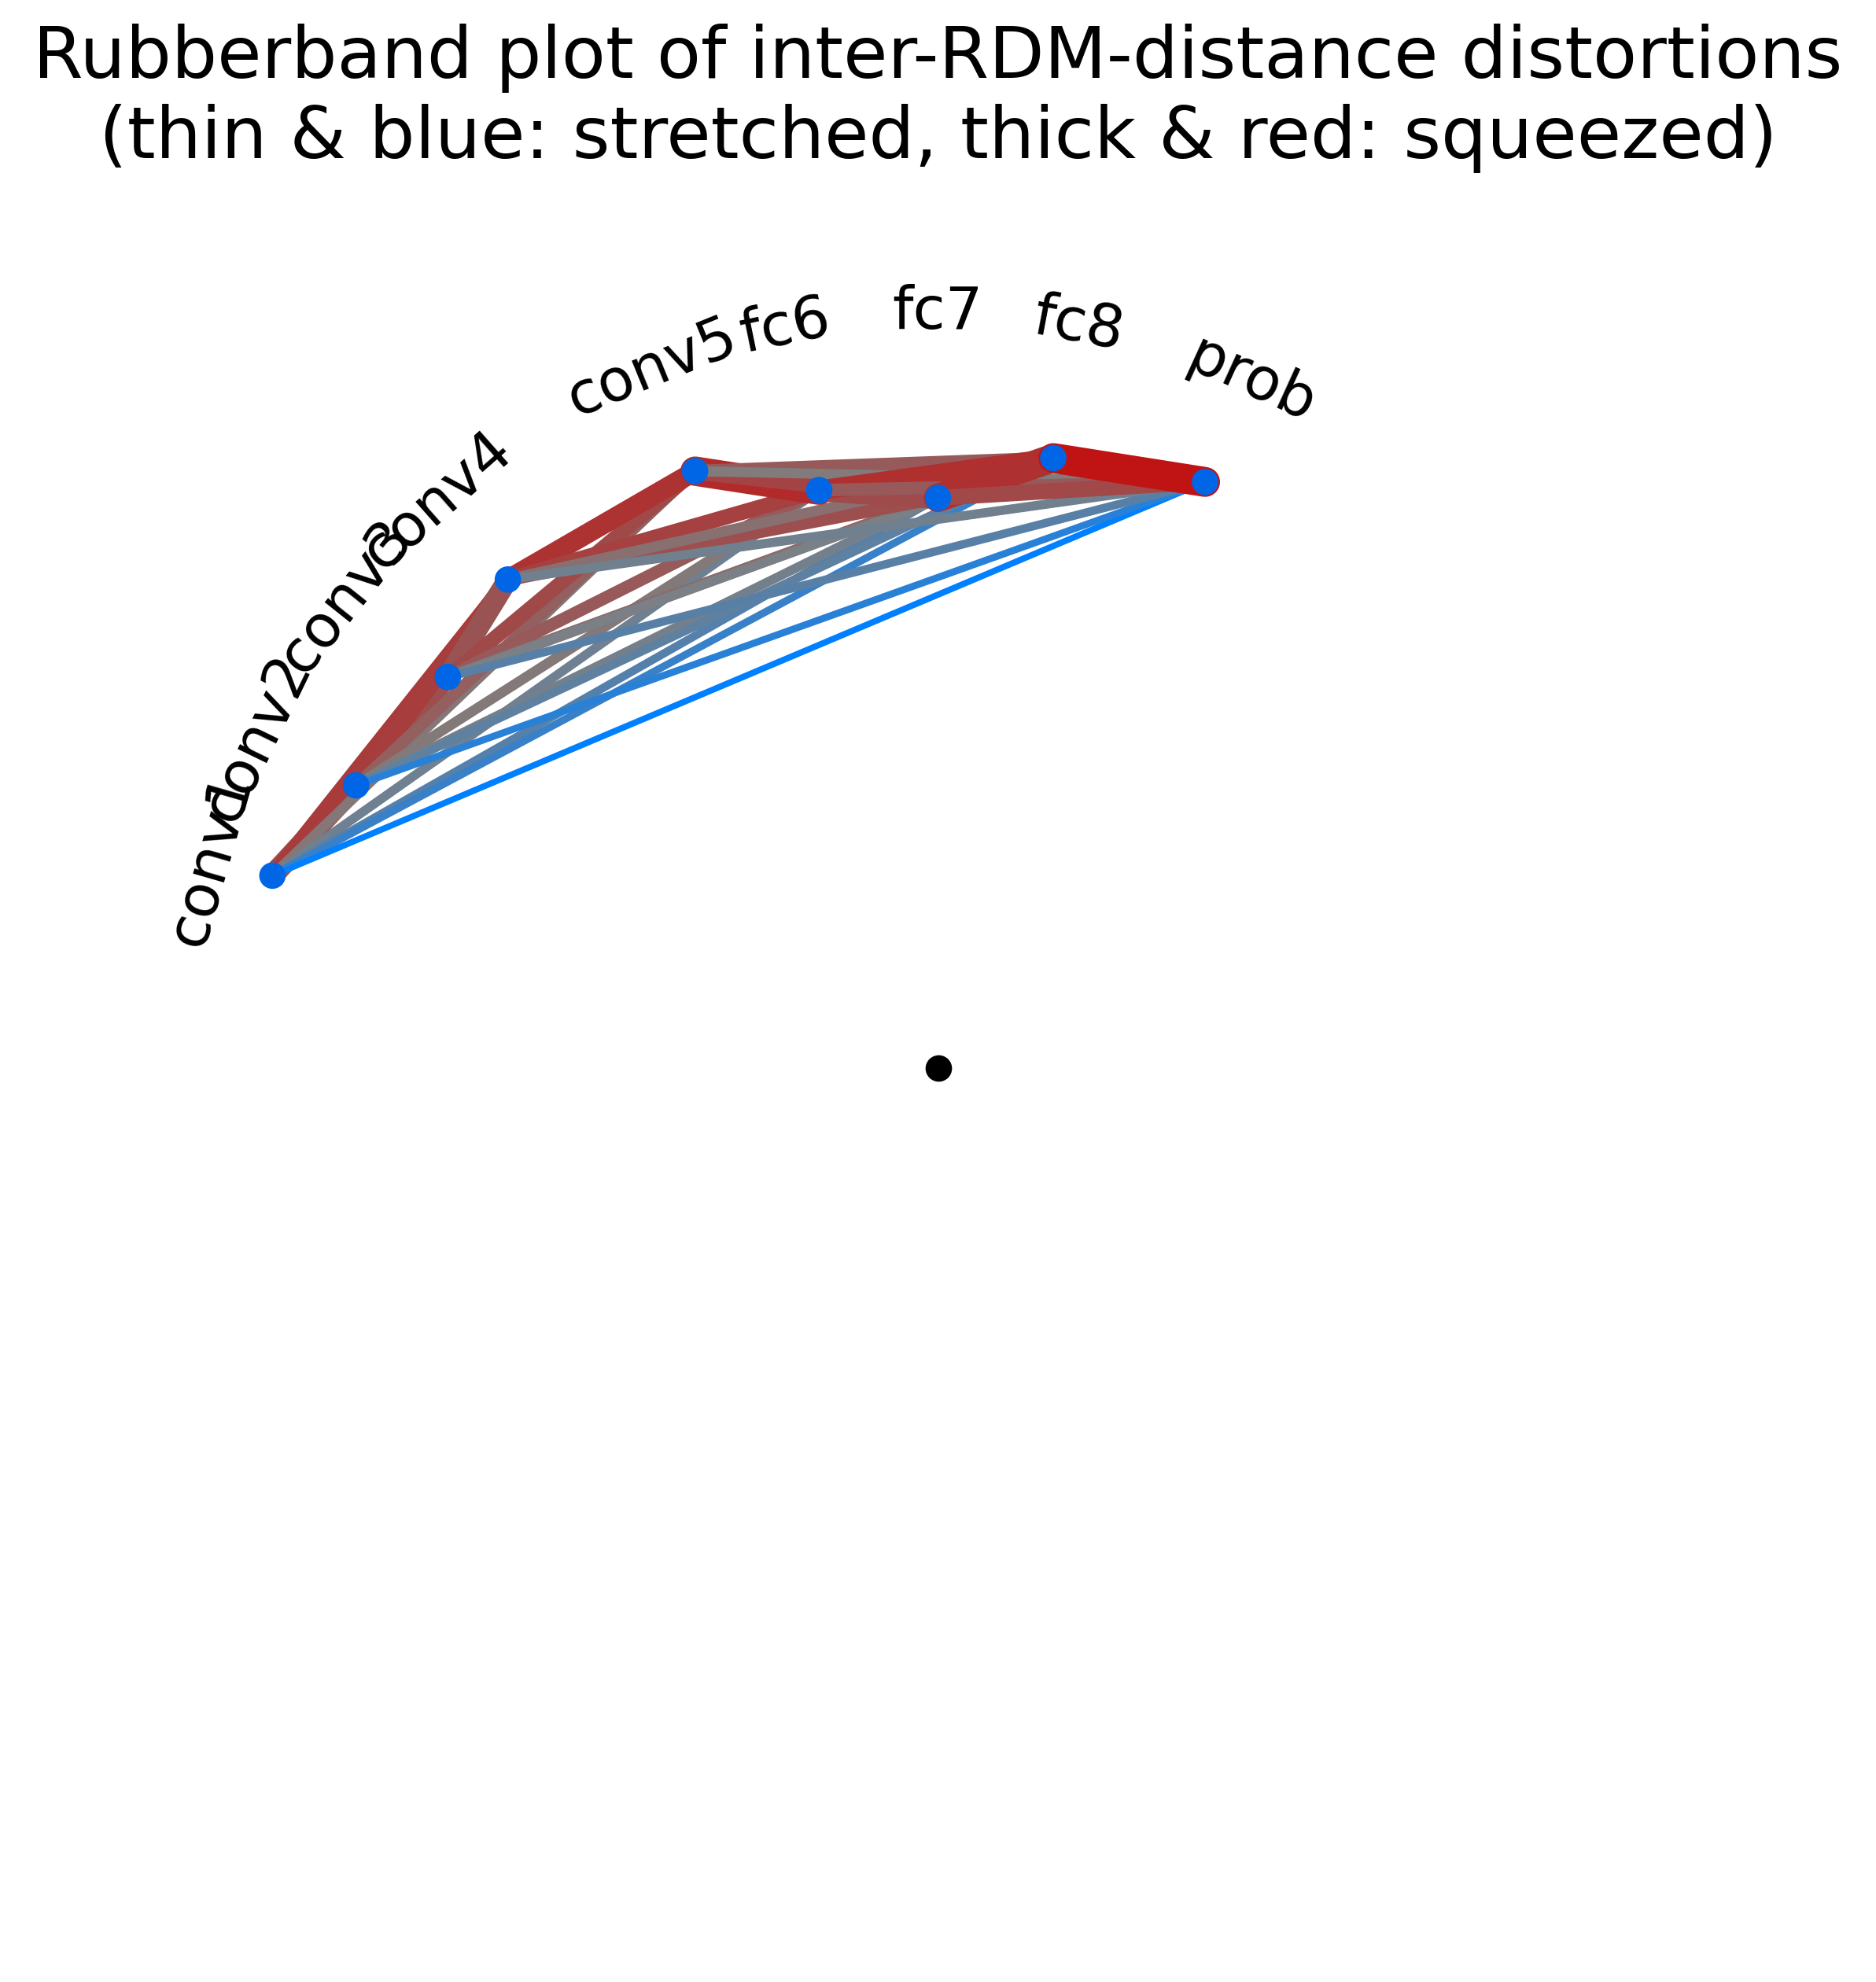

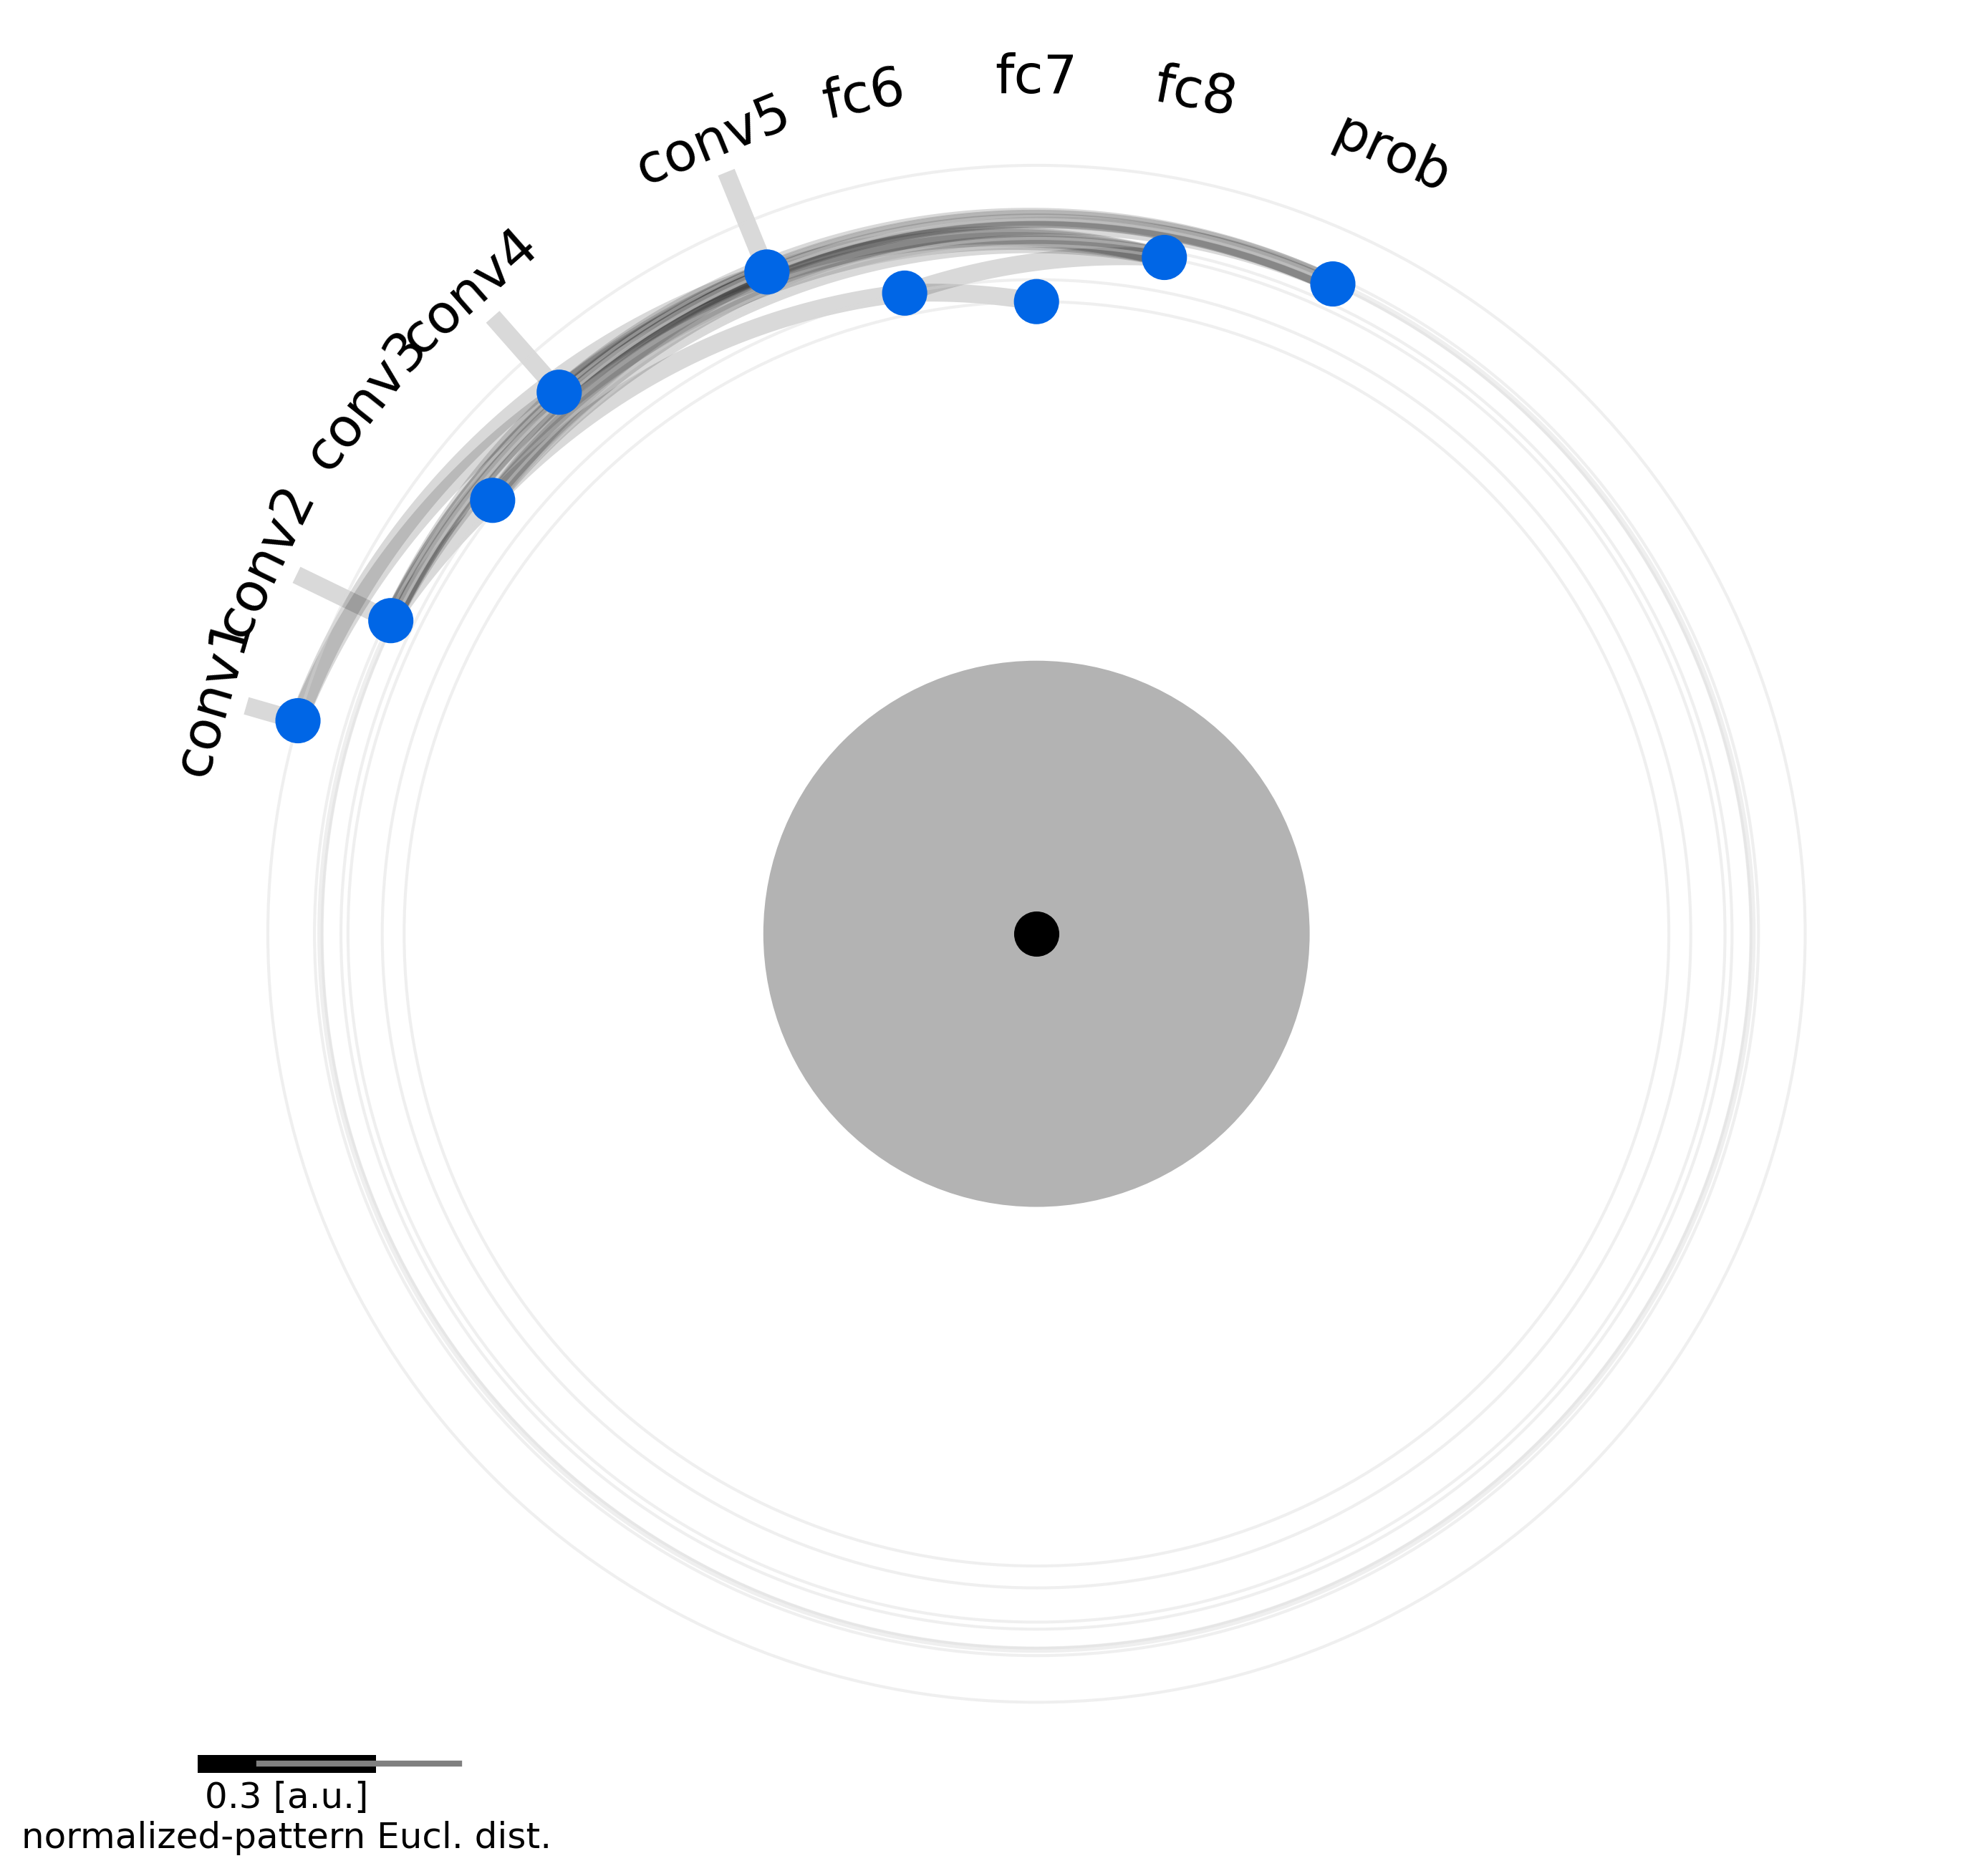

In [4]:
rsatoolbox.vis.map_model_comparison(results_1, rdms_data, error_bars='sem')


Tests deactivated because crossvalidation alone gives no uncertainty estimate.

FDR q < 0.01 (36 model-pair comparisons)
Error bars indicate the 99.0% confidence interval.Inter-RDM distances were measured by the Pearson correlation distance (proportional to squared Euclidean distance after RDM centering and divisive normalization).Inter-RDM distances are mapped as Euclidean distance (proportional to the square root of correlation or cosine distance if RDMs were appropriately normalized).

Formula-based average distance: 0.9194


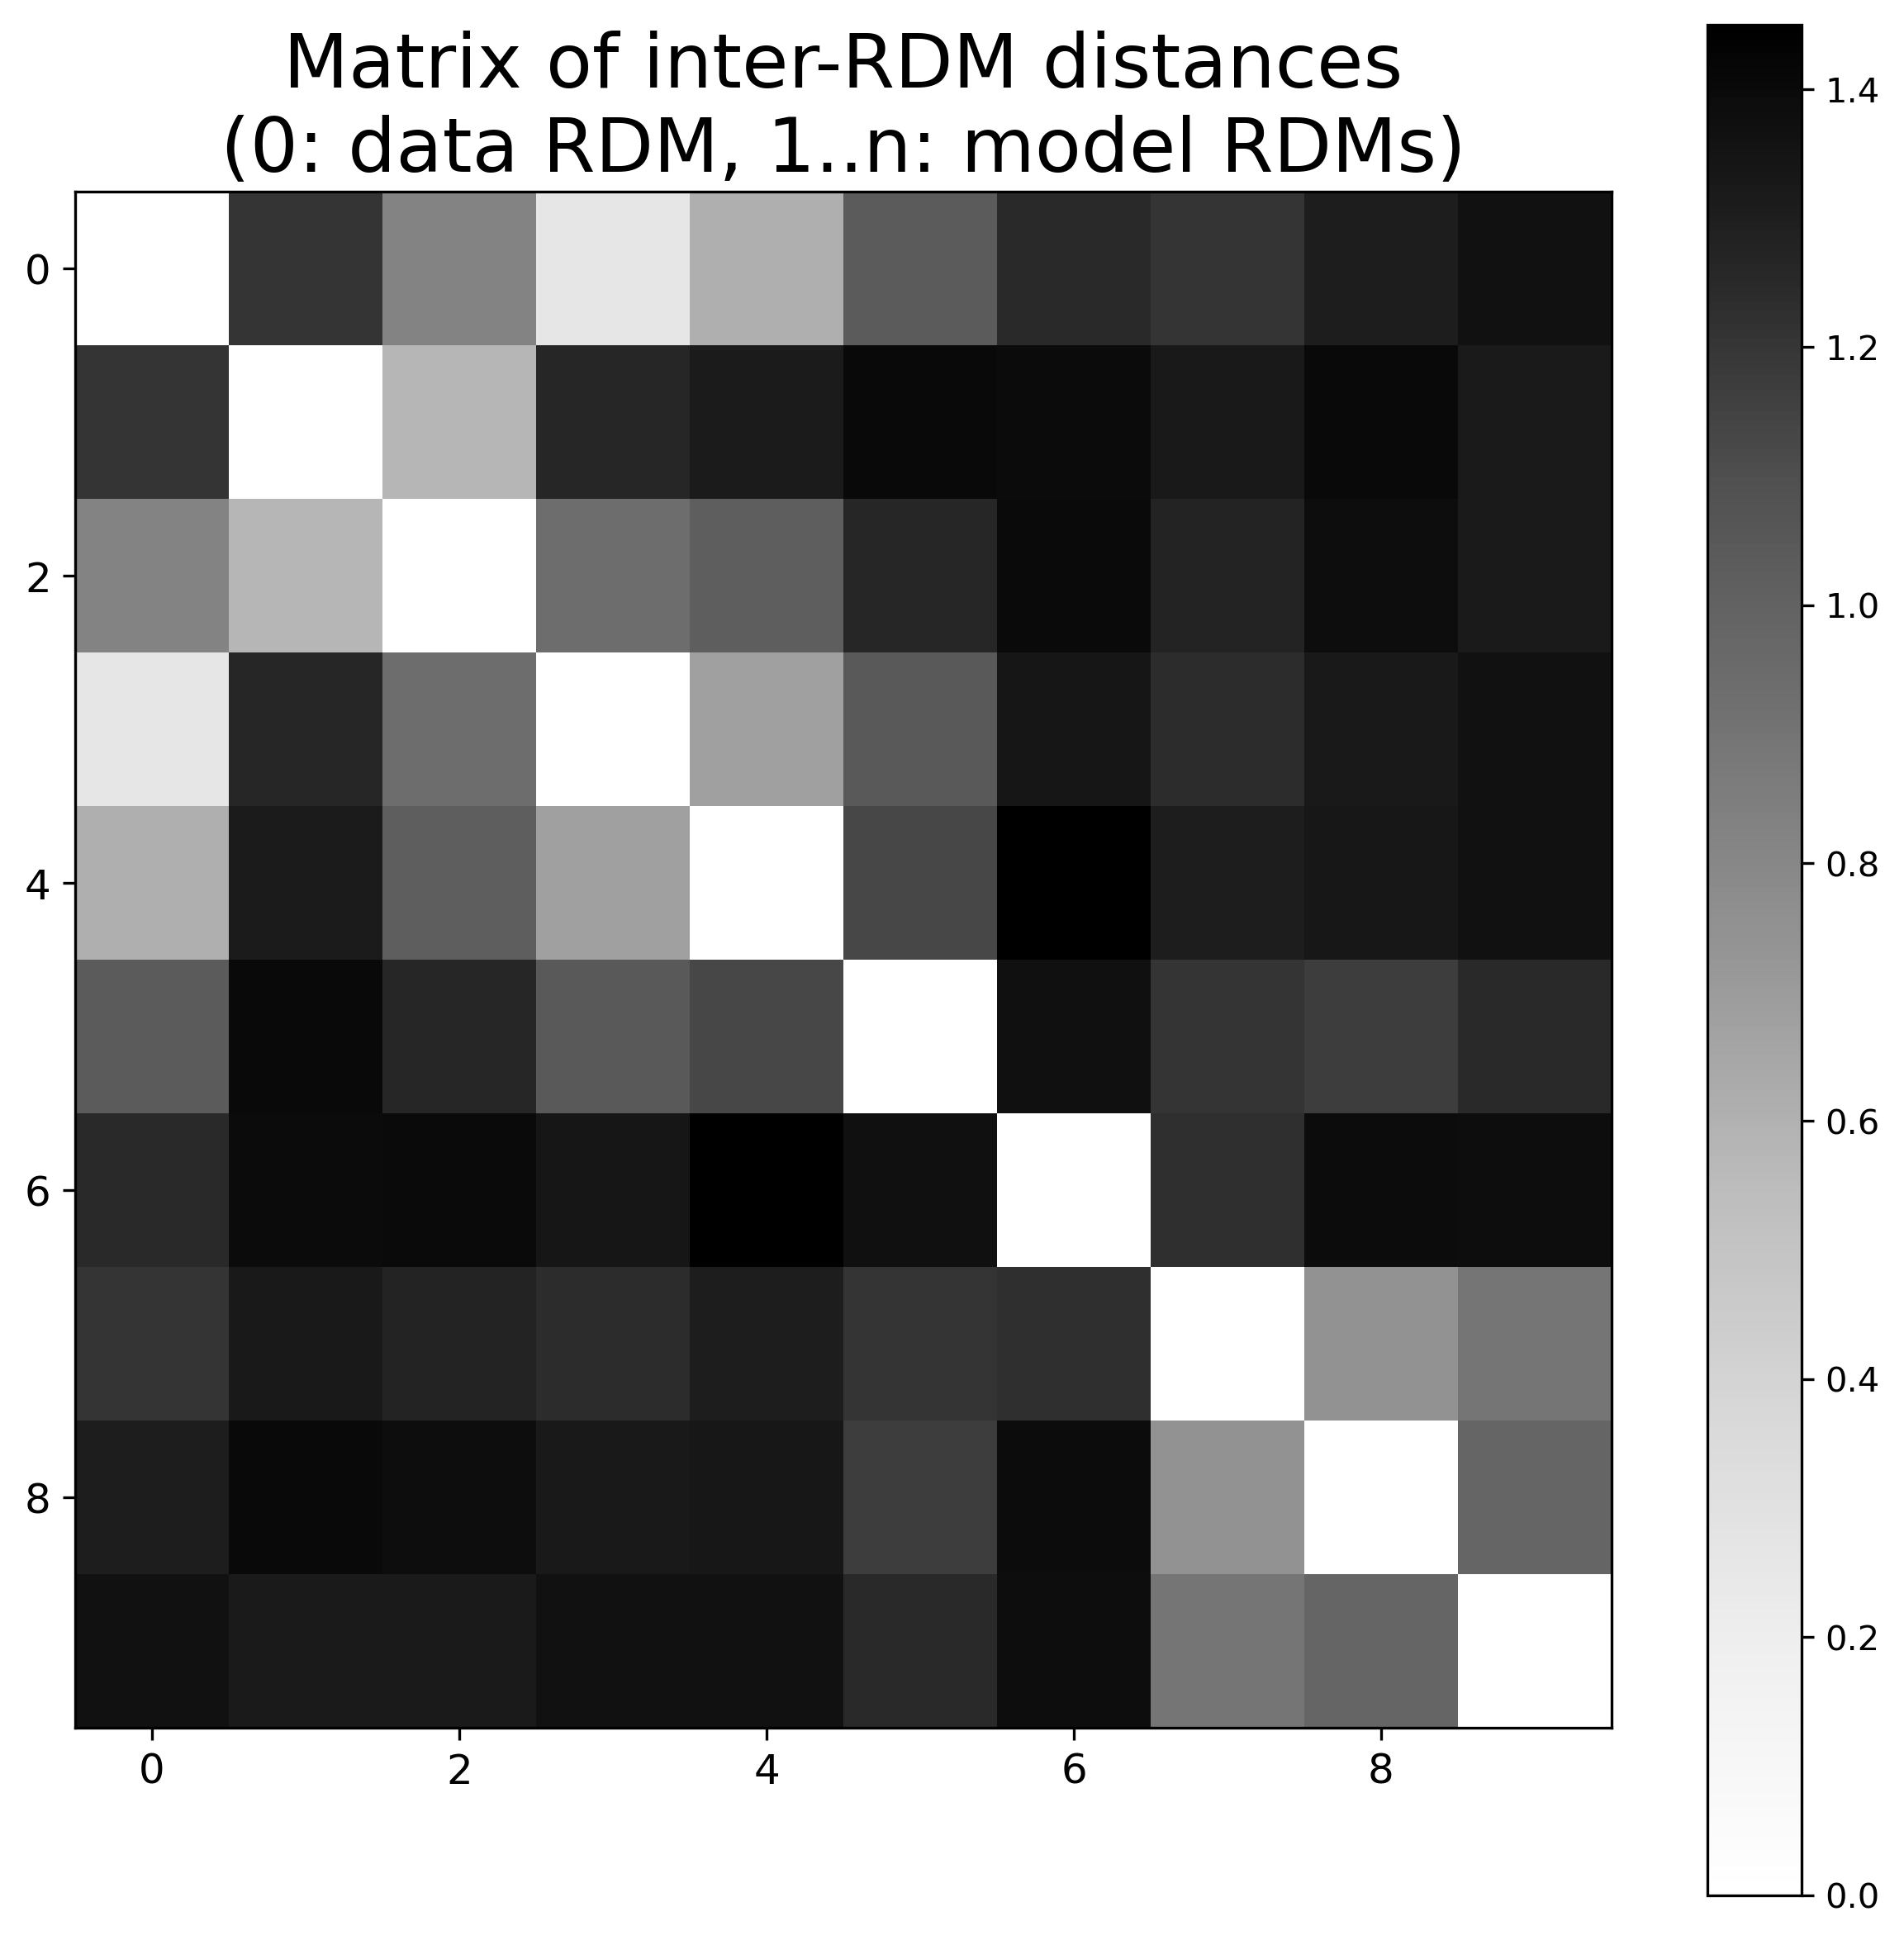

(10, 10)
 MDS did not converge. Doubling number of iterations.
 MDS did not converge. Doubling number of iterations.
Pearson r(RDM dist, 2d-map dist): 0.7209
Pearson r(RDM dist, 2d-map dist) for model-data dists: 1.0000
Spearman r(RDM dist, 2d-map dist) for model-data dists: 1.0000


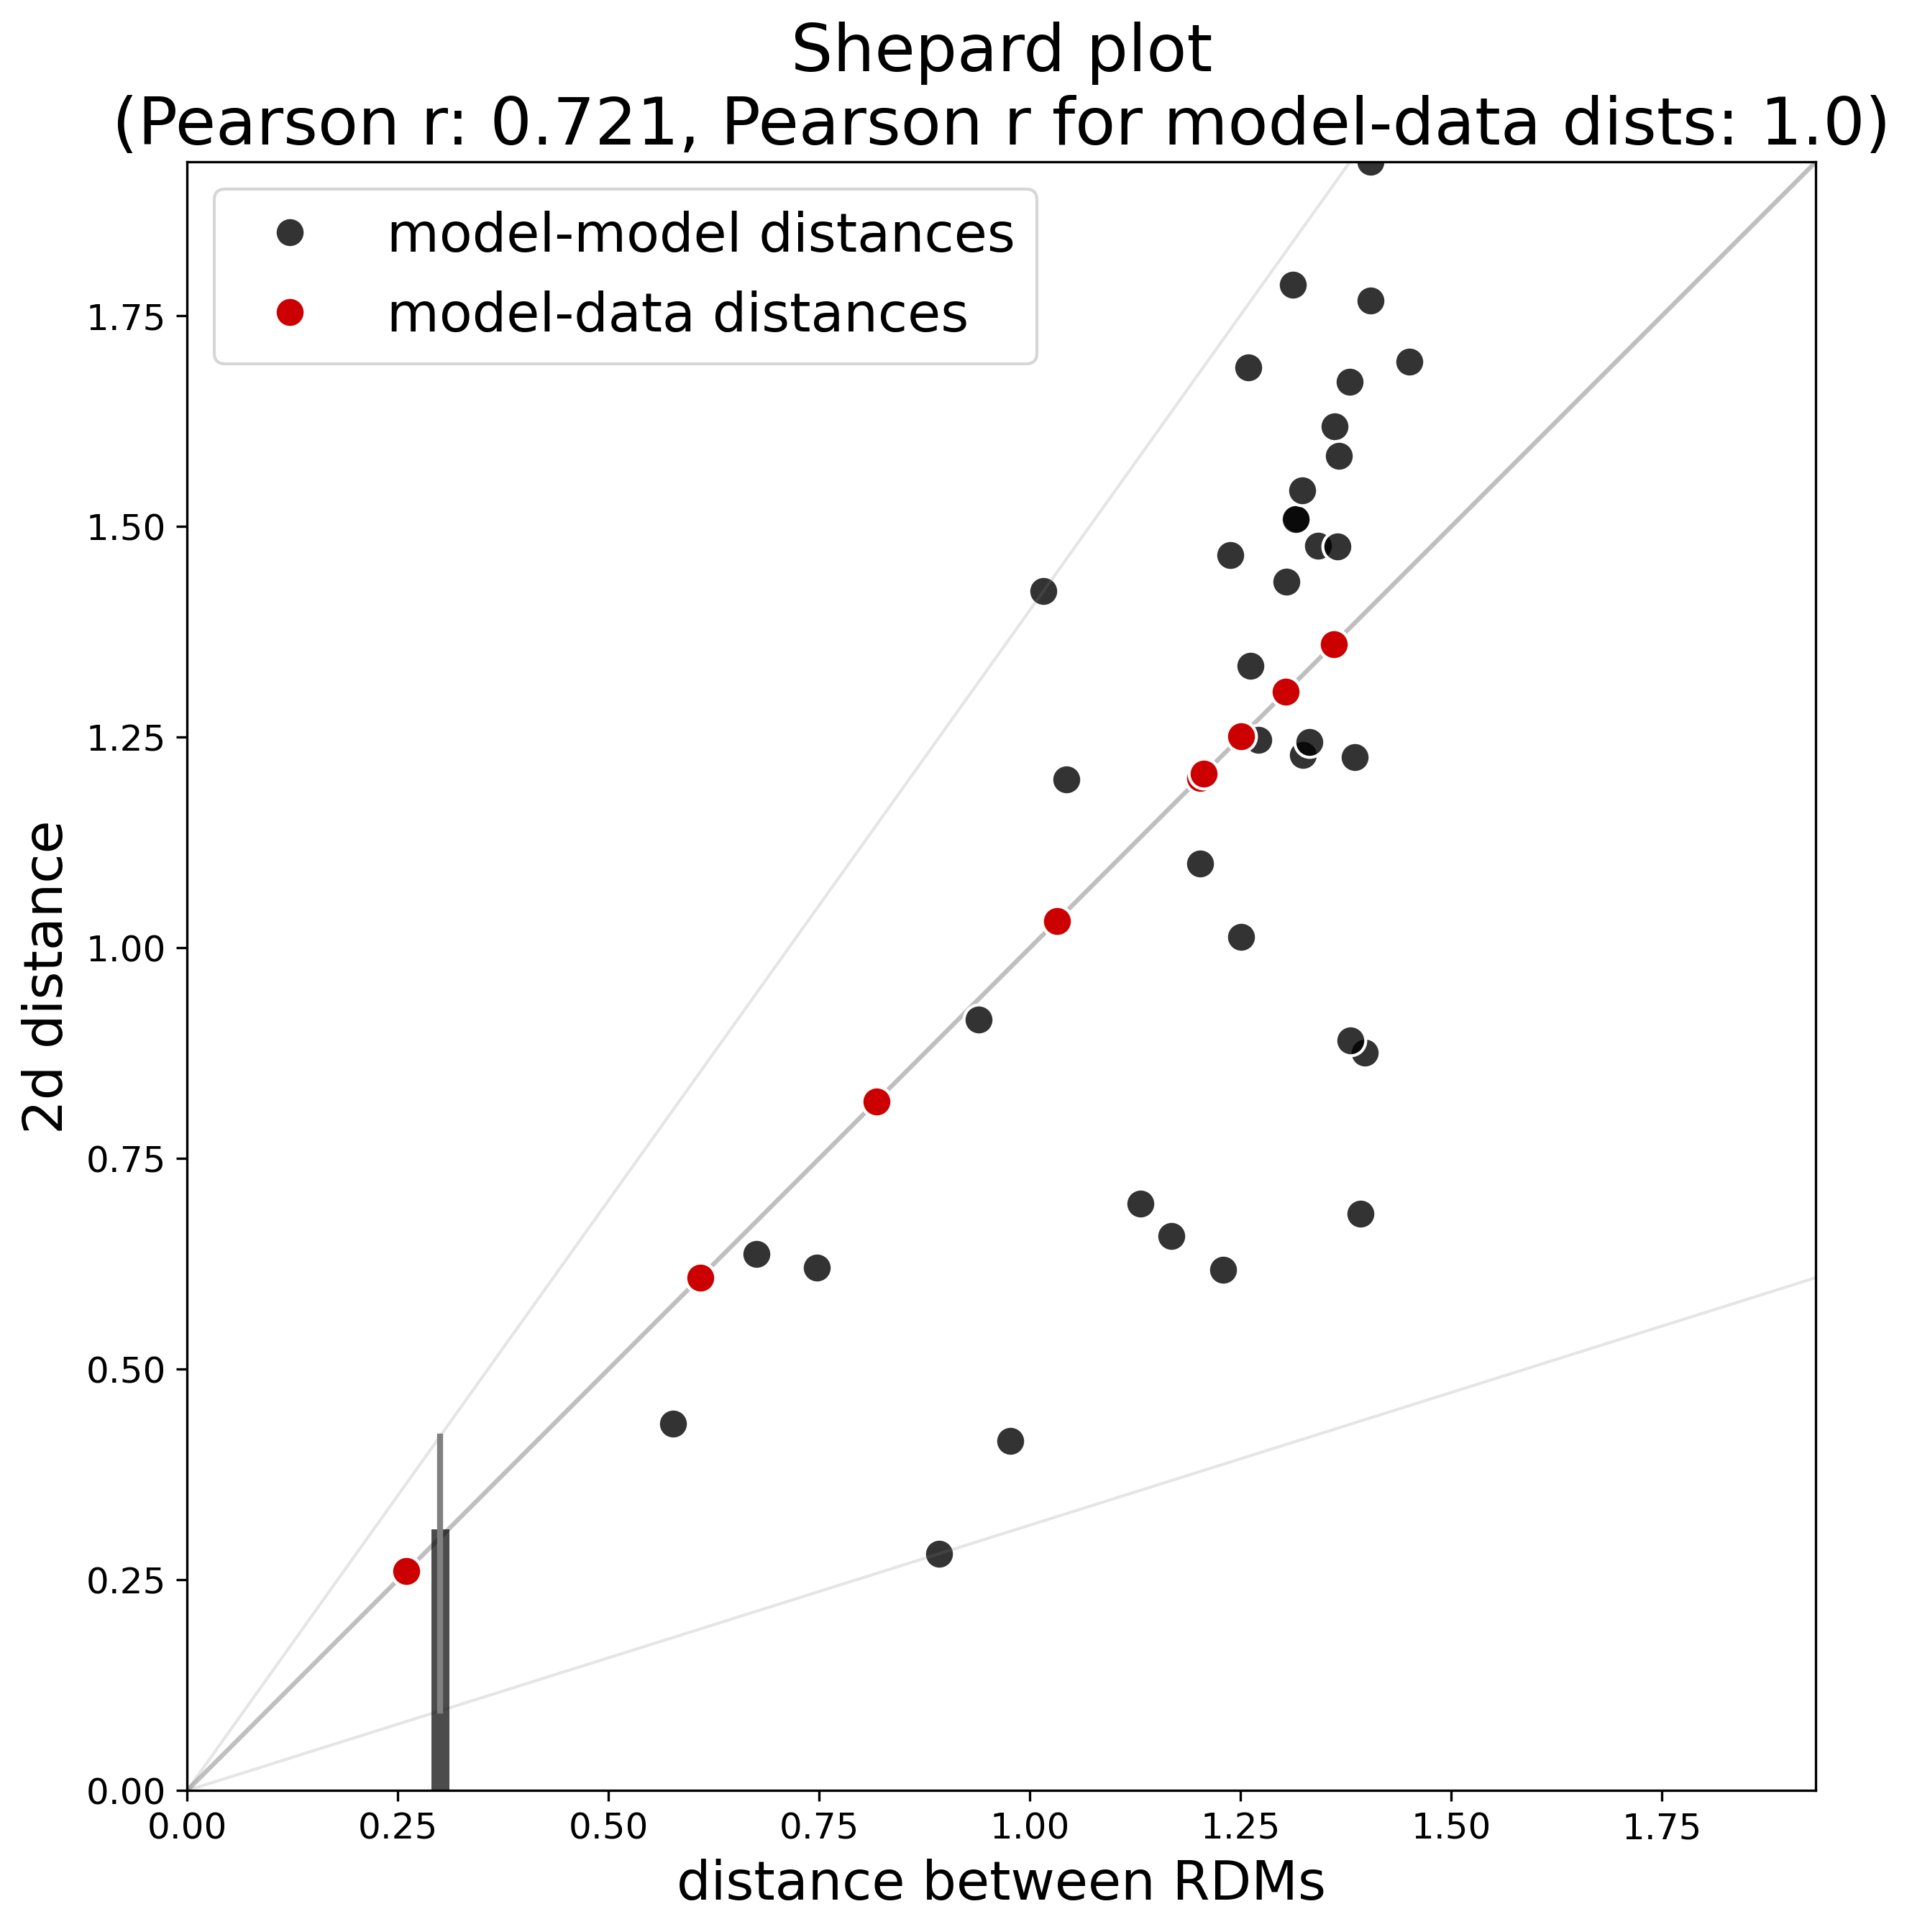

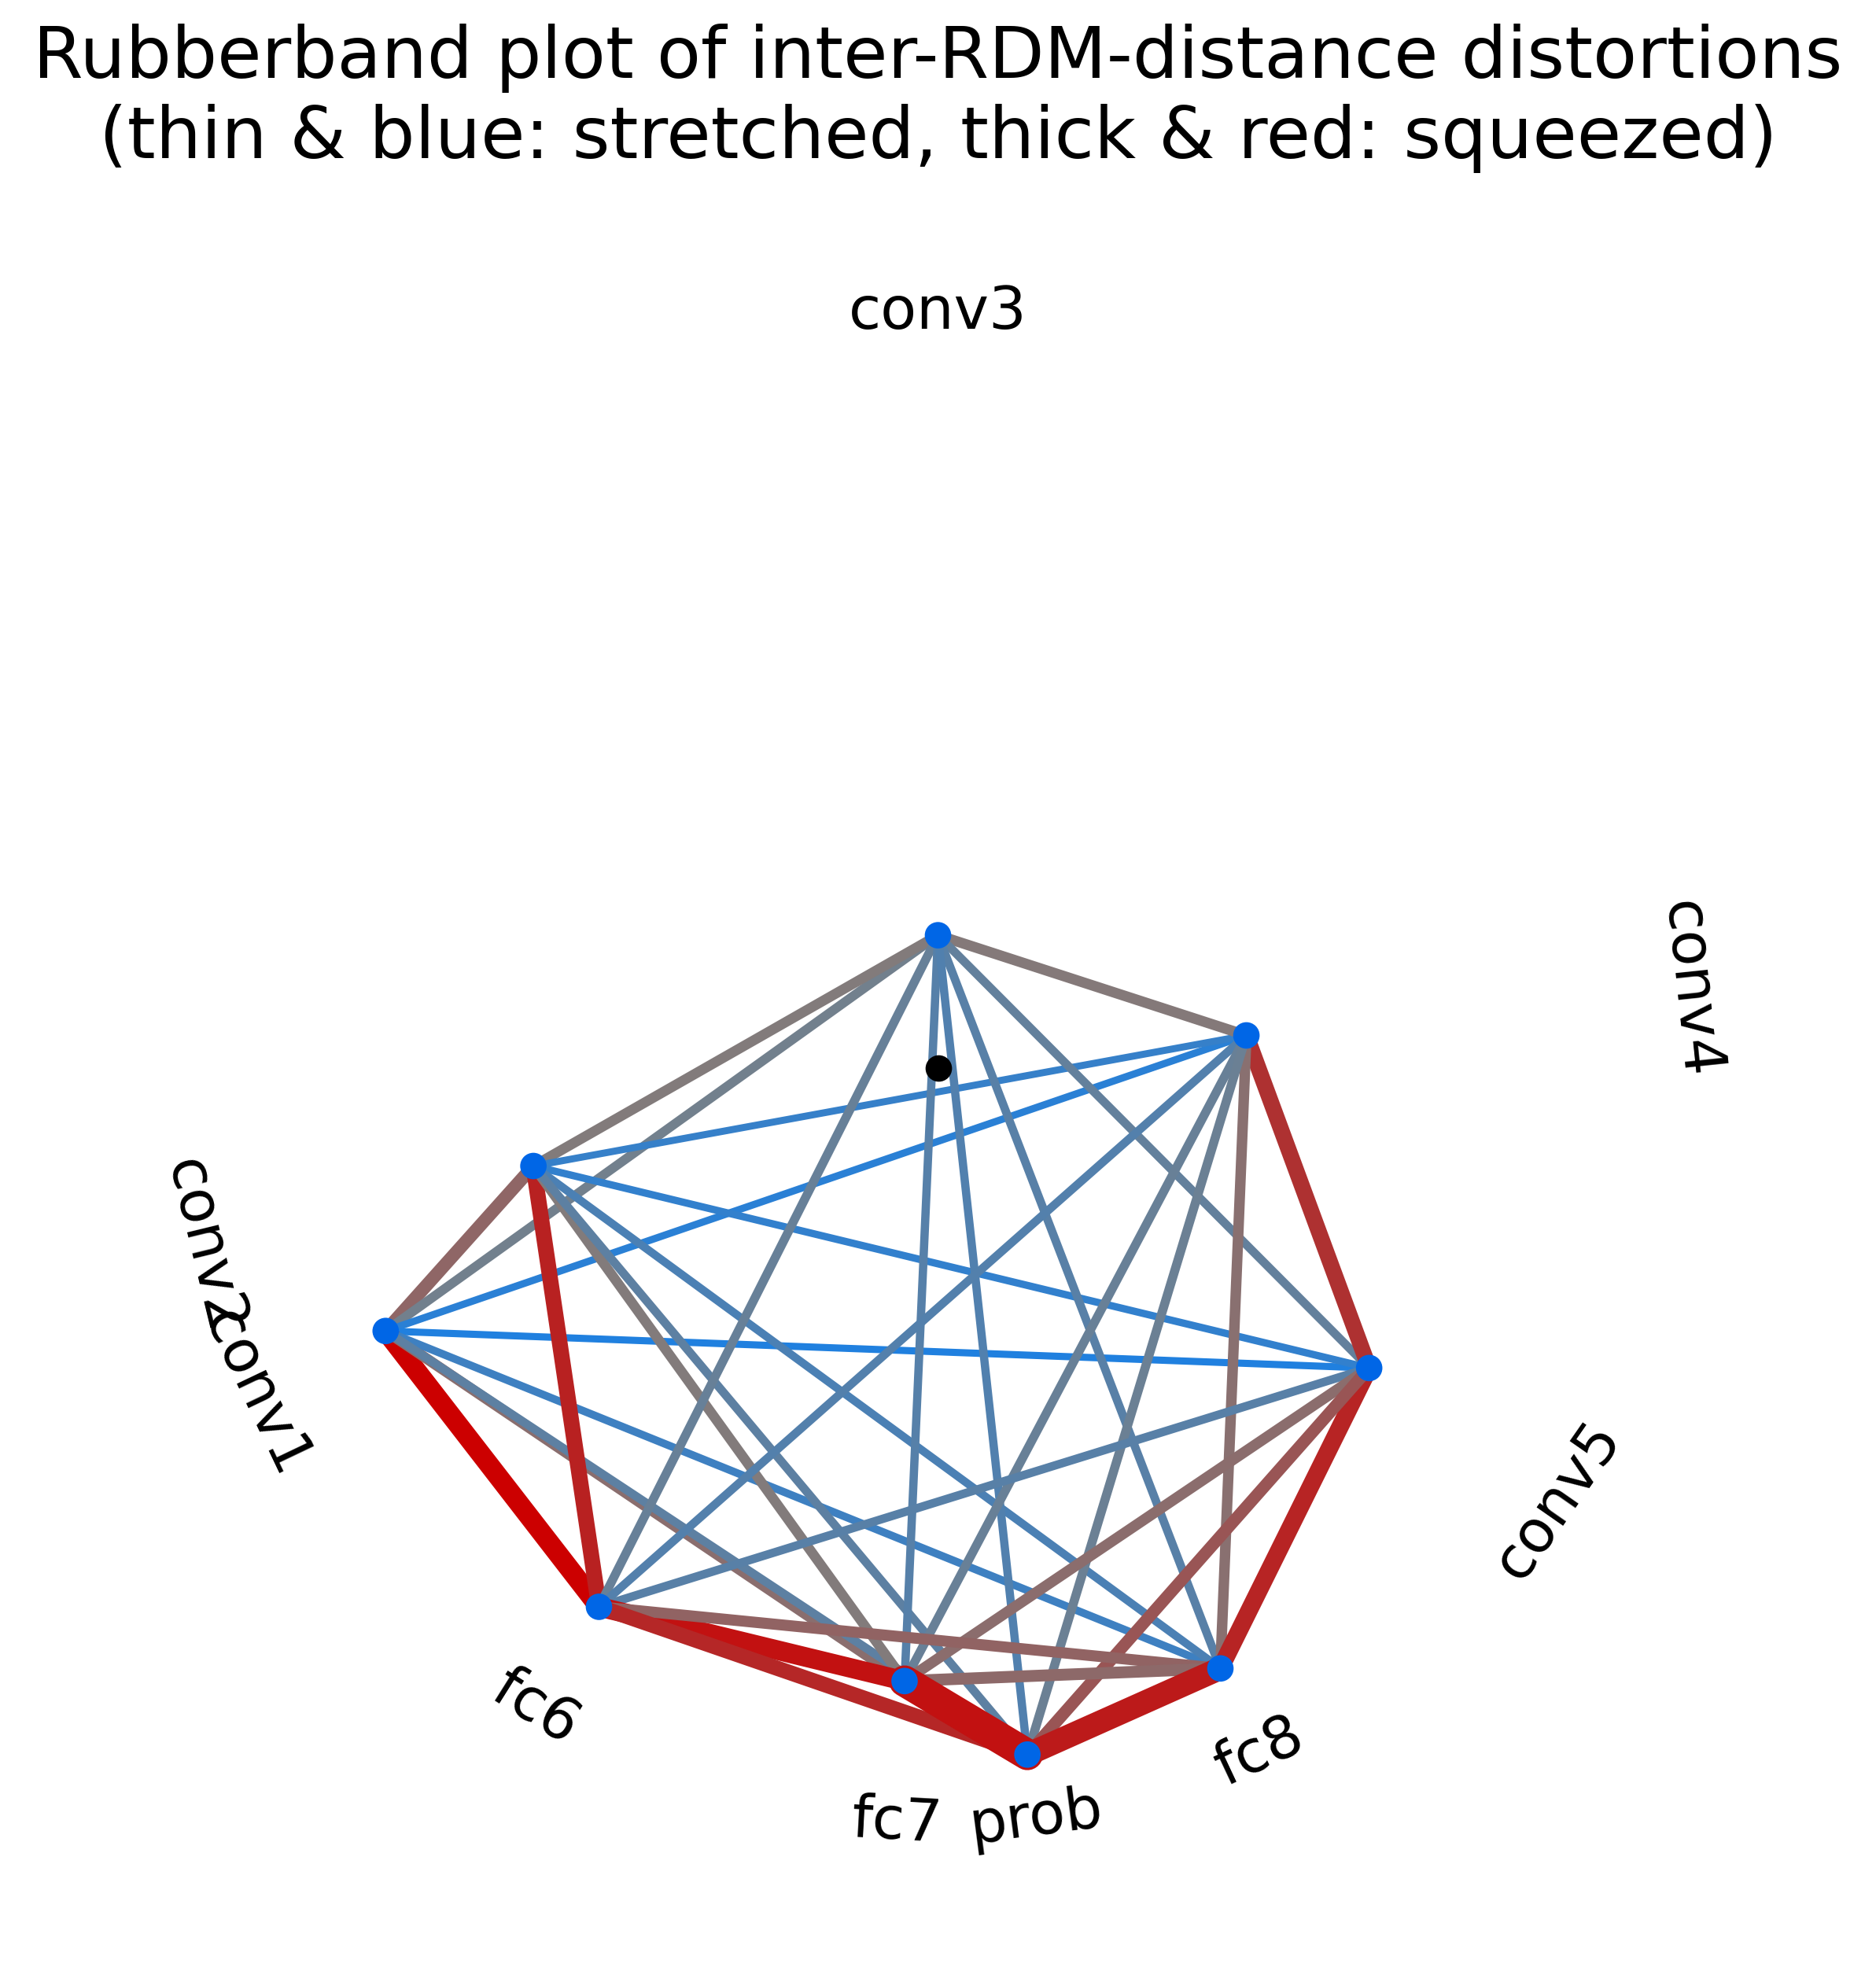

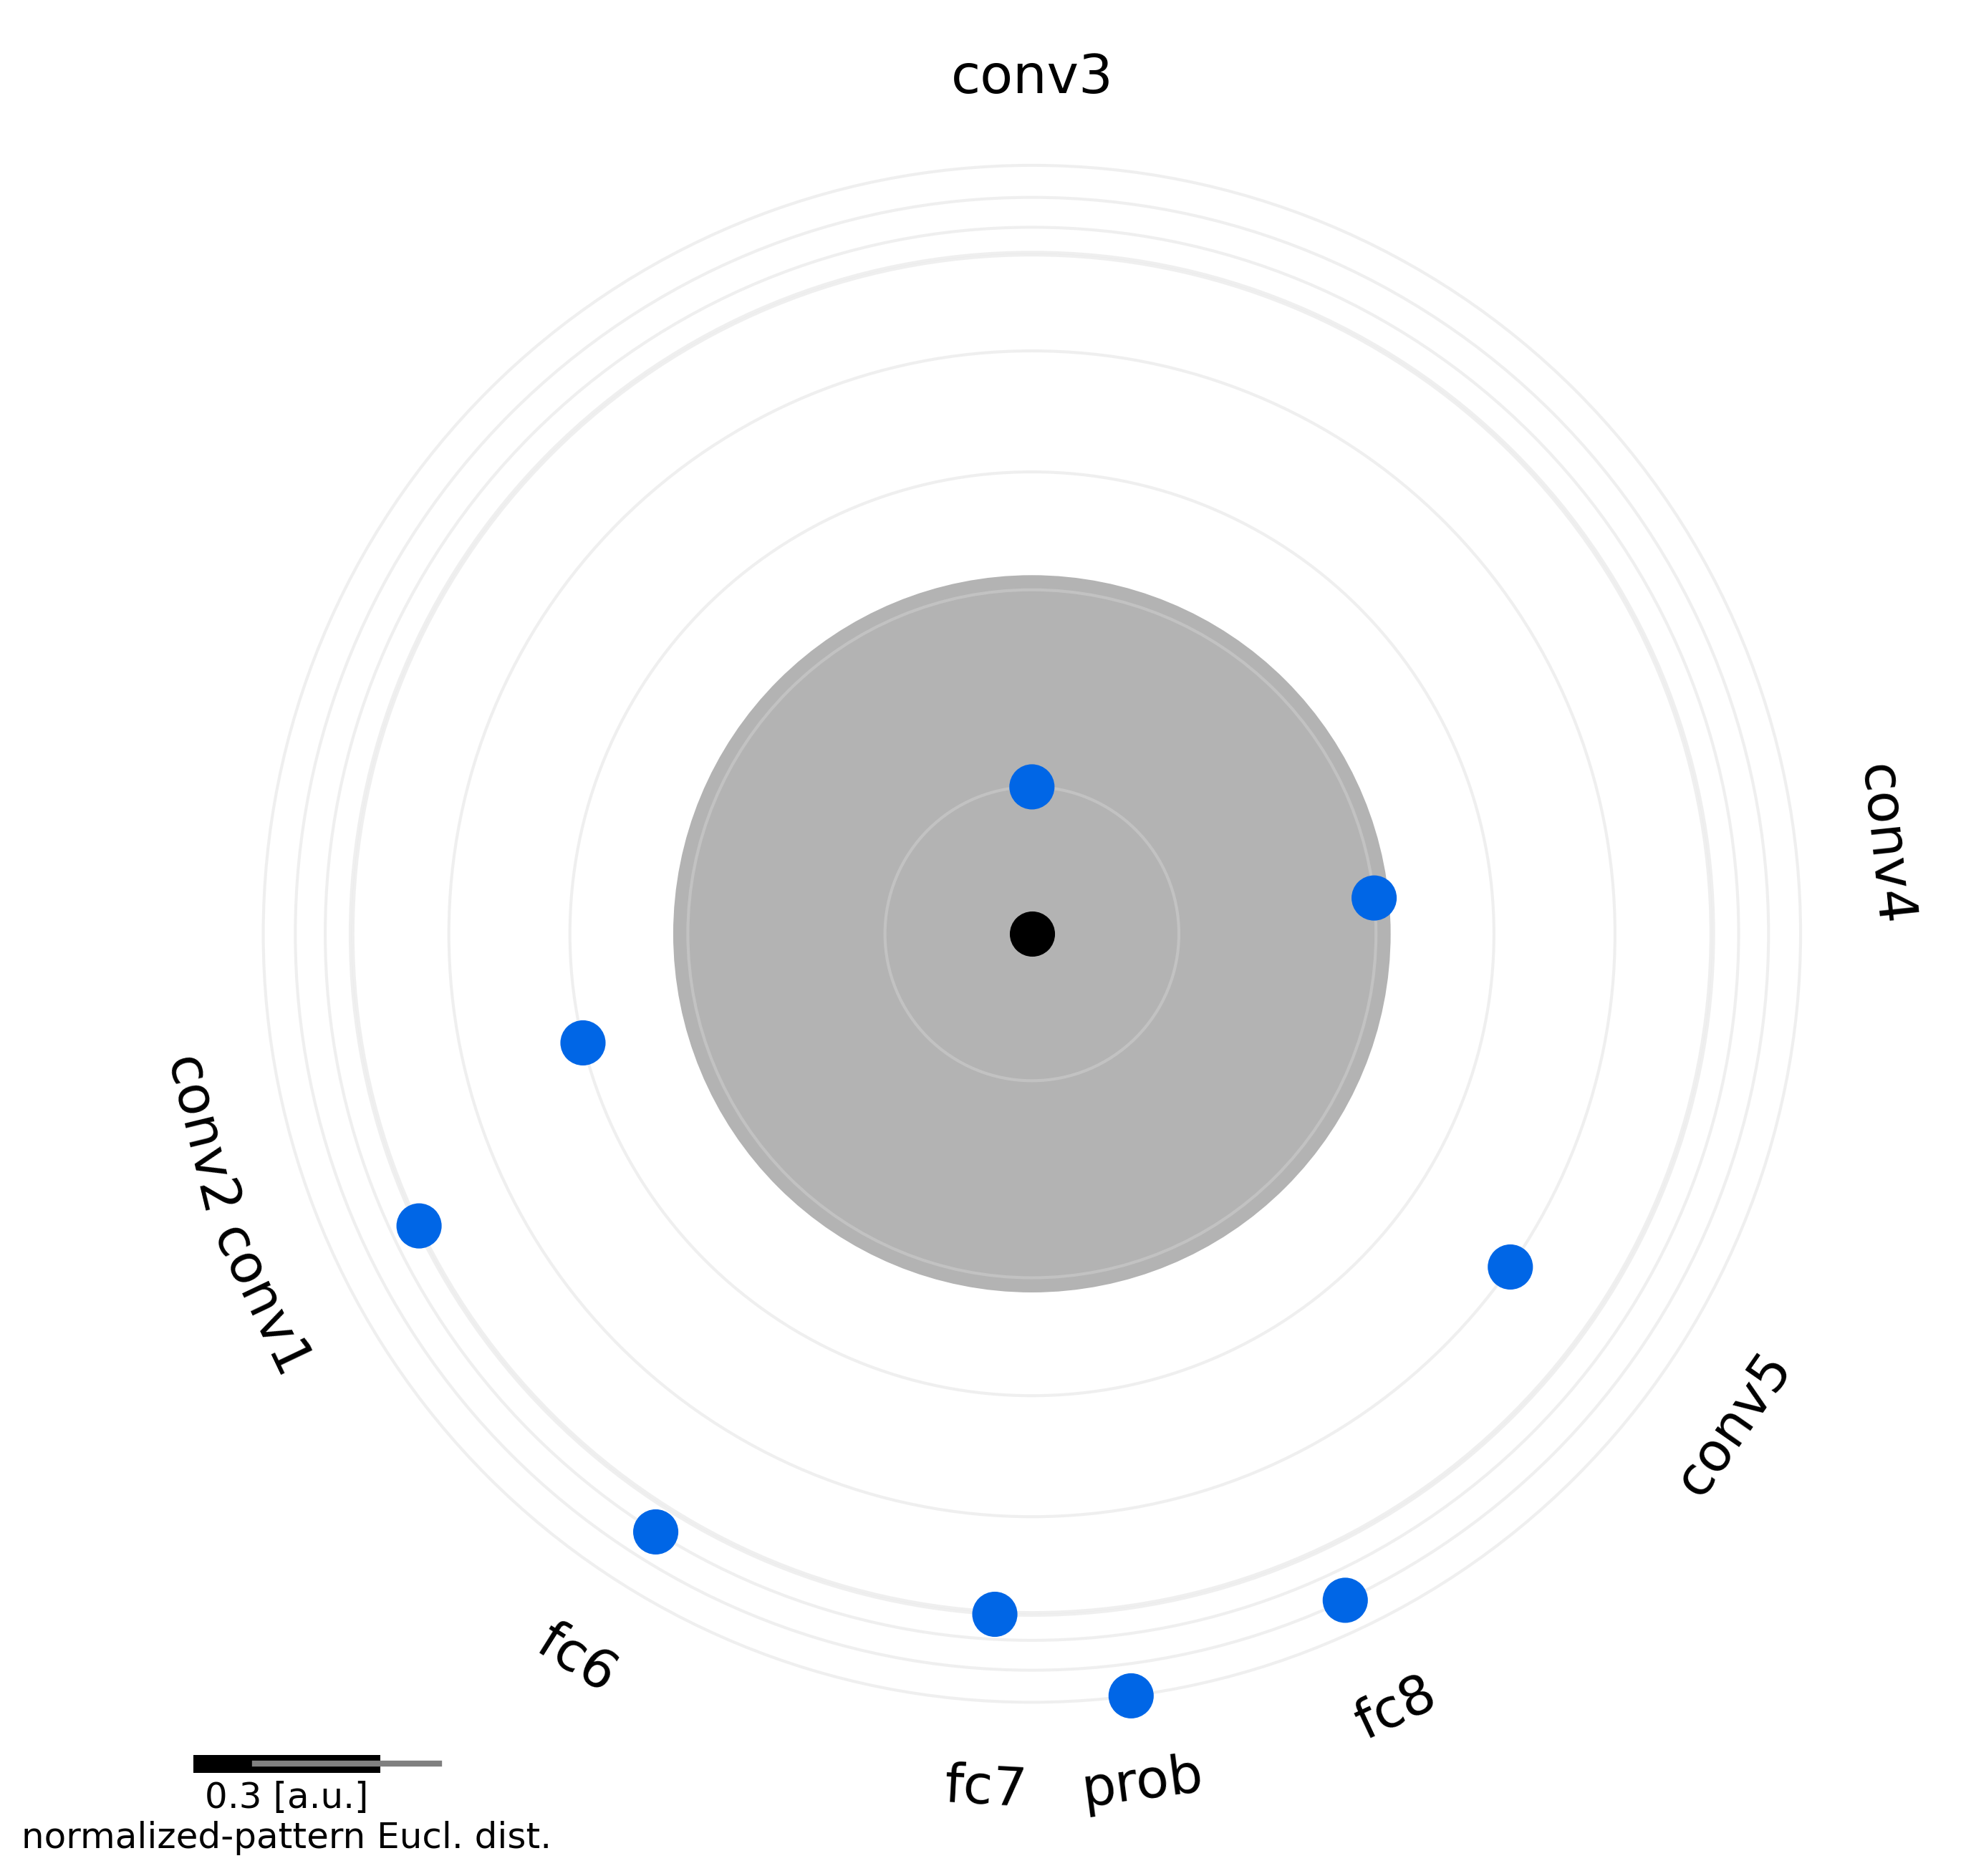

In [5]:
# plot results
rsatoolbox.vis.map_model_comparison(
    results_2_cv, rdms_data=rdms_data)

Model comparisons: two-tailed, FDR q < 0.01 (36 model-pair comparisons)
Inference by bootstrap resampling (100 bootstrap samples) of subjects and experimental conditions. 
Error bars indicate the 99.0% confidence interval.
One-sided comparisons of each model performance against 0 and against the lower-bound estimate of the noise ceiling are Bonferroni-corrected for 9 models.
Inter-RDM distances were measured by the Pearson correlation distance (proportional to squared Euclidean distance after RDM centering and divisive normalization).Inter-RDM distances are mapped as Euclidean distance (proportional to the square root of correlation or cosine distance if RDMs were appropriately normalized).

Formula-based average distance: 0.9194


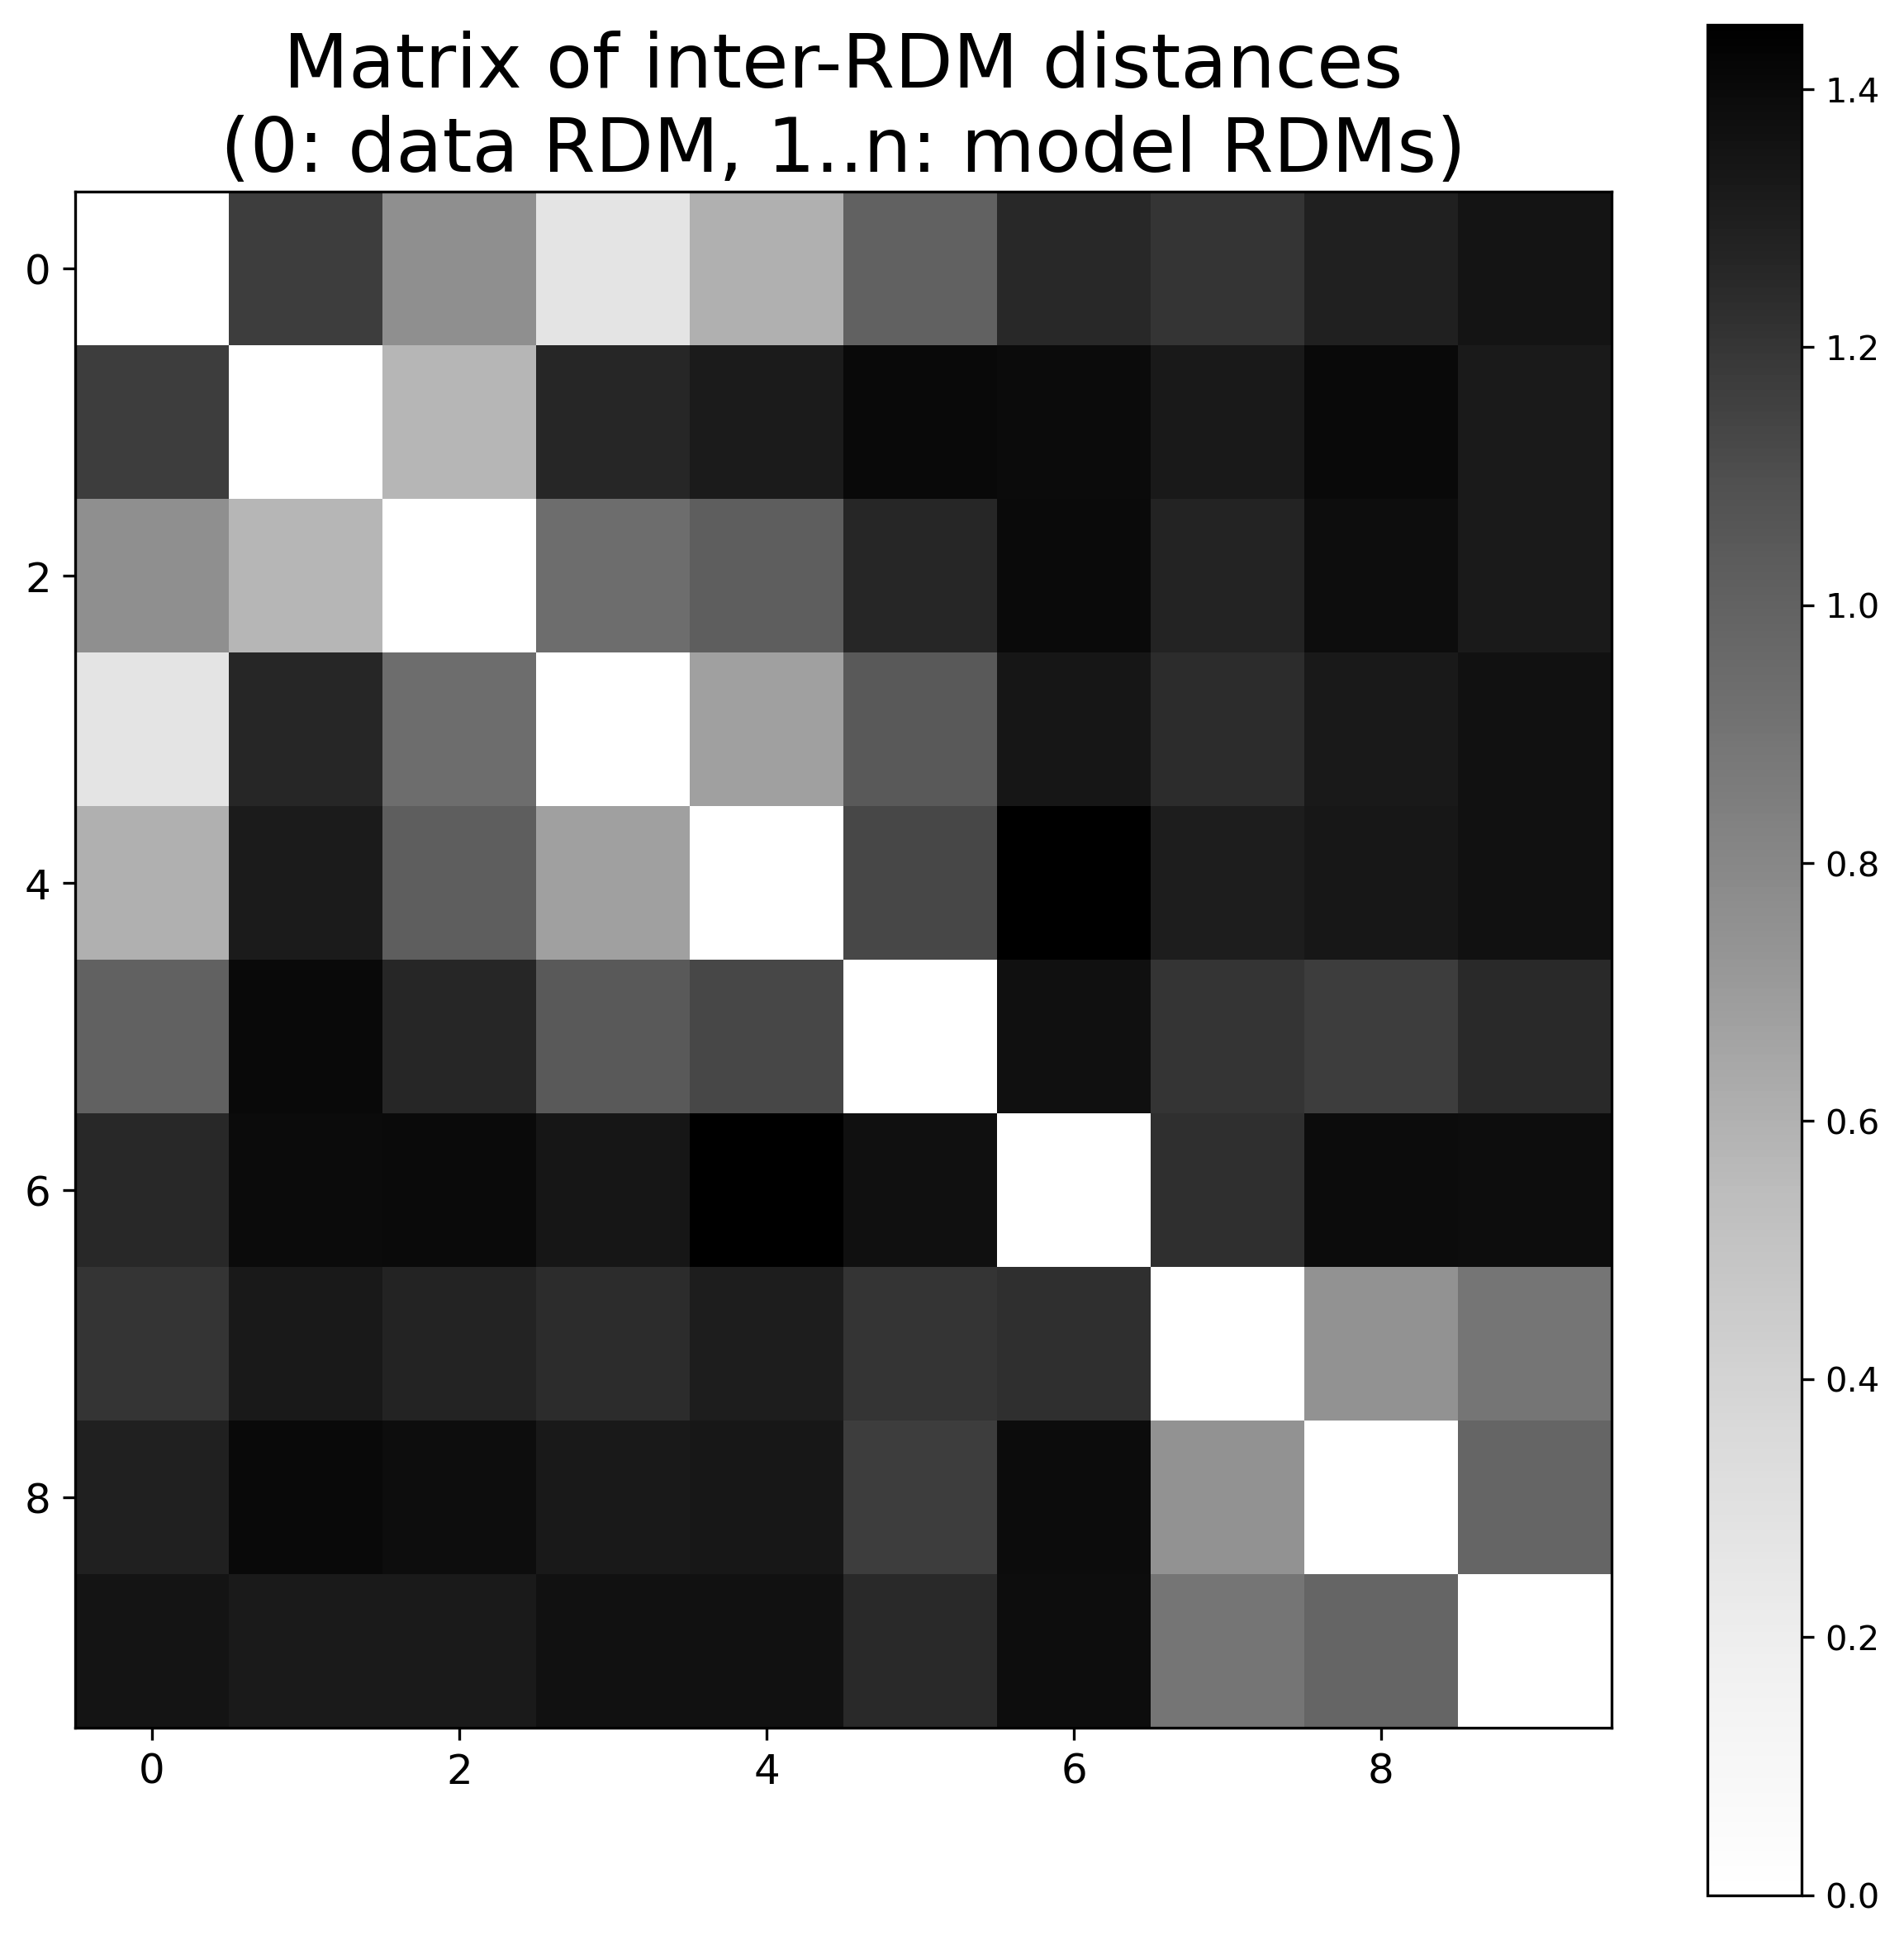

(10, 10)
 MDS did not converge. Doubling number of iterations.
 MDS did not converge. Doubling number of iterations.
Pearson r(RDM dist, 2d-map dist): 0.7516
Pearson r(RDM dist, 2d-map dist) for model-data dists: 1.0000
Spearman r(RDM dist, 2d-map dist) for model-data dists: 1.0000


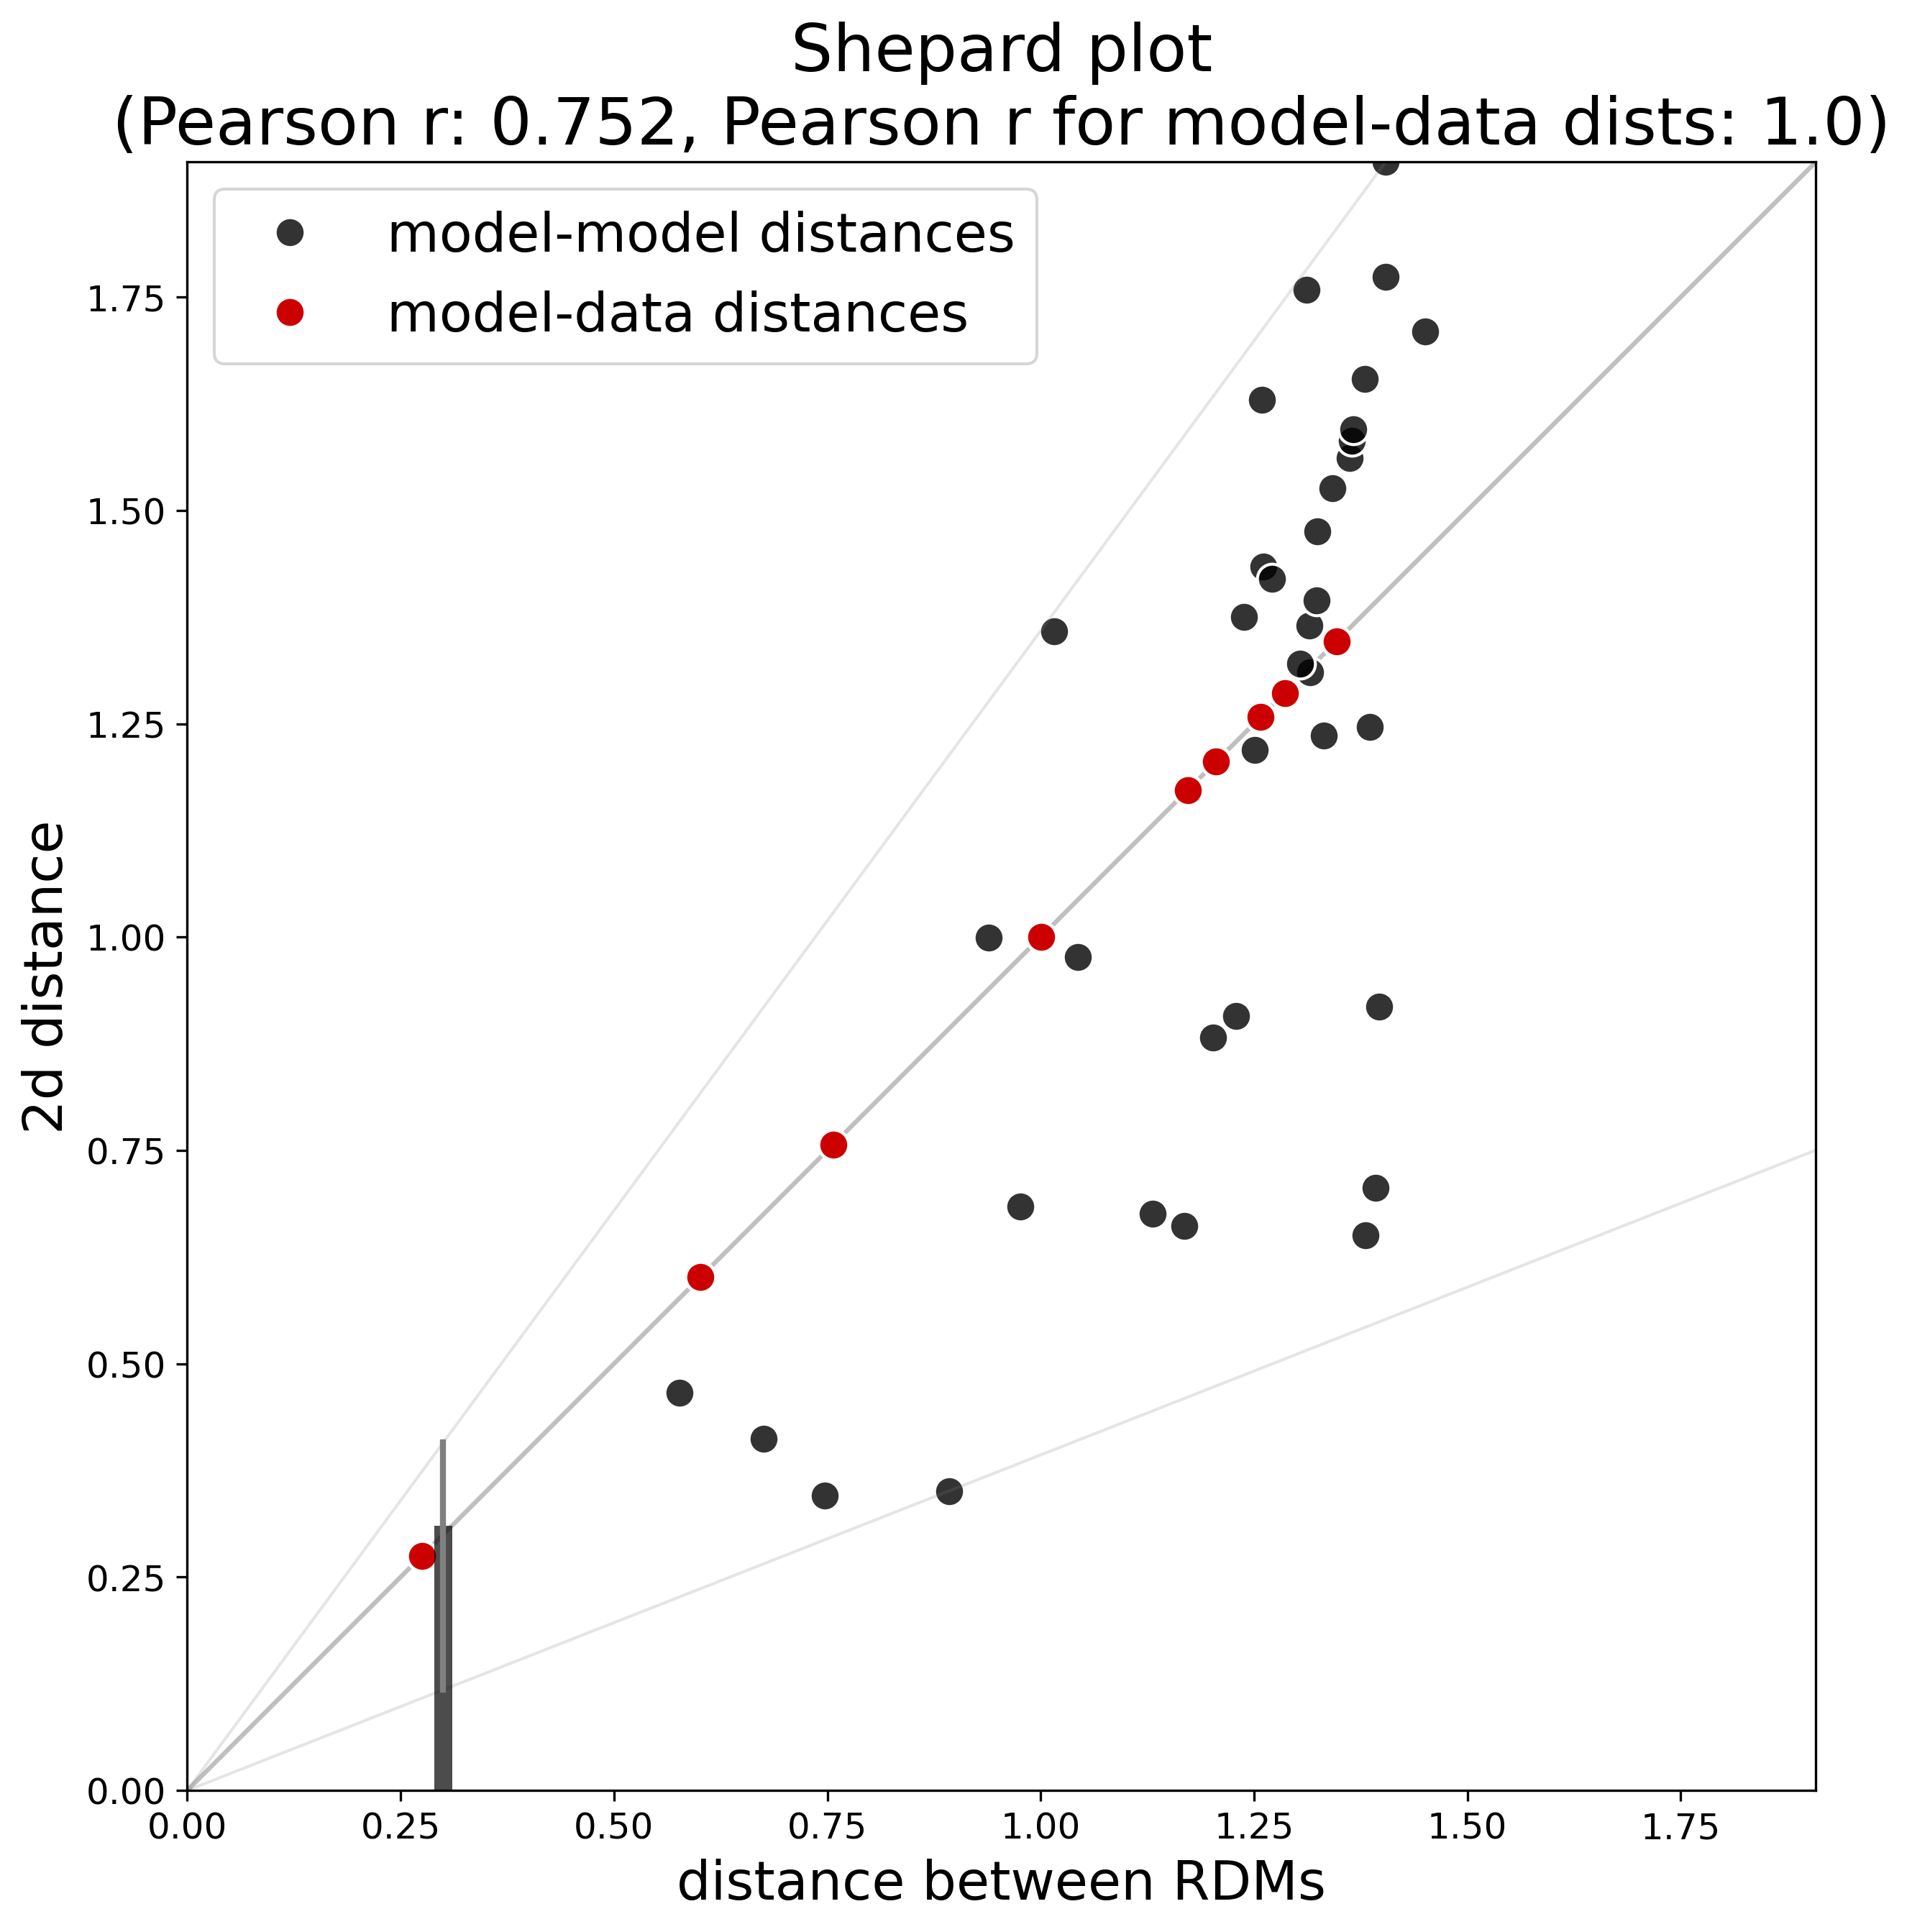

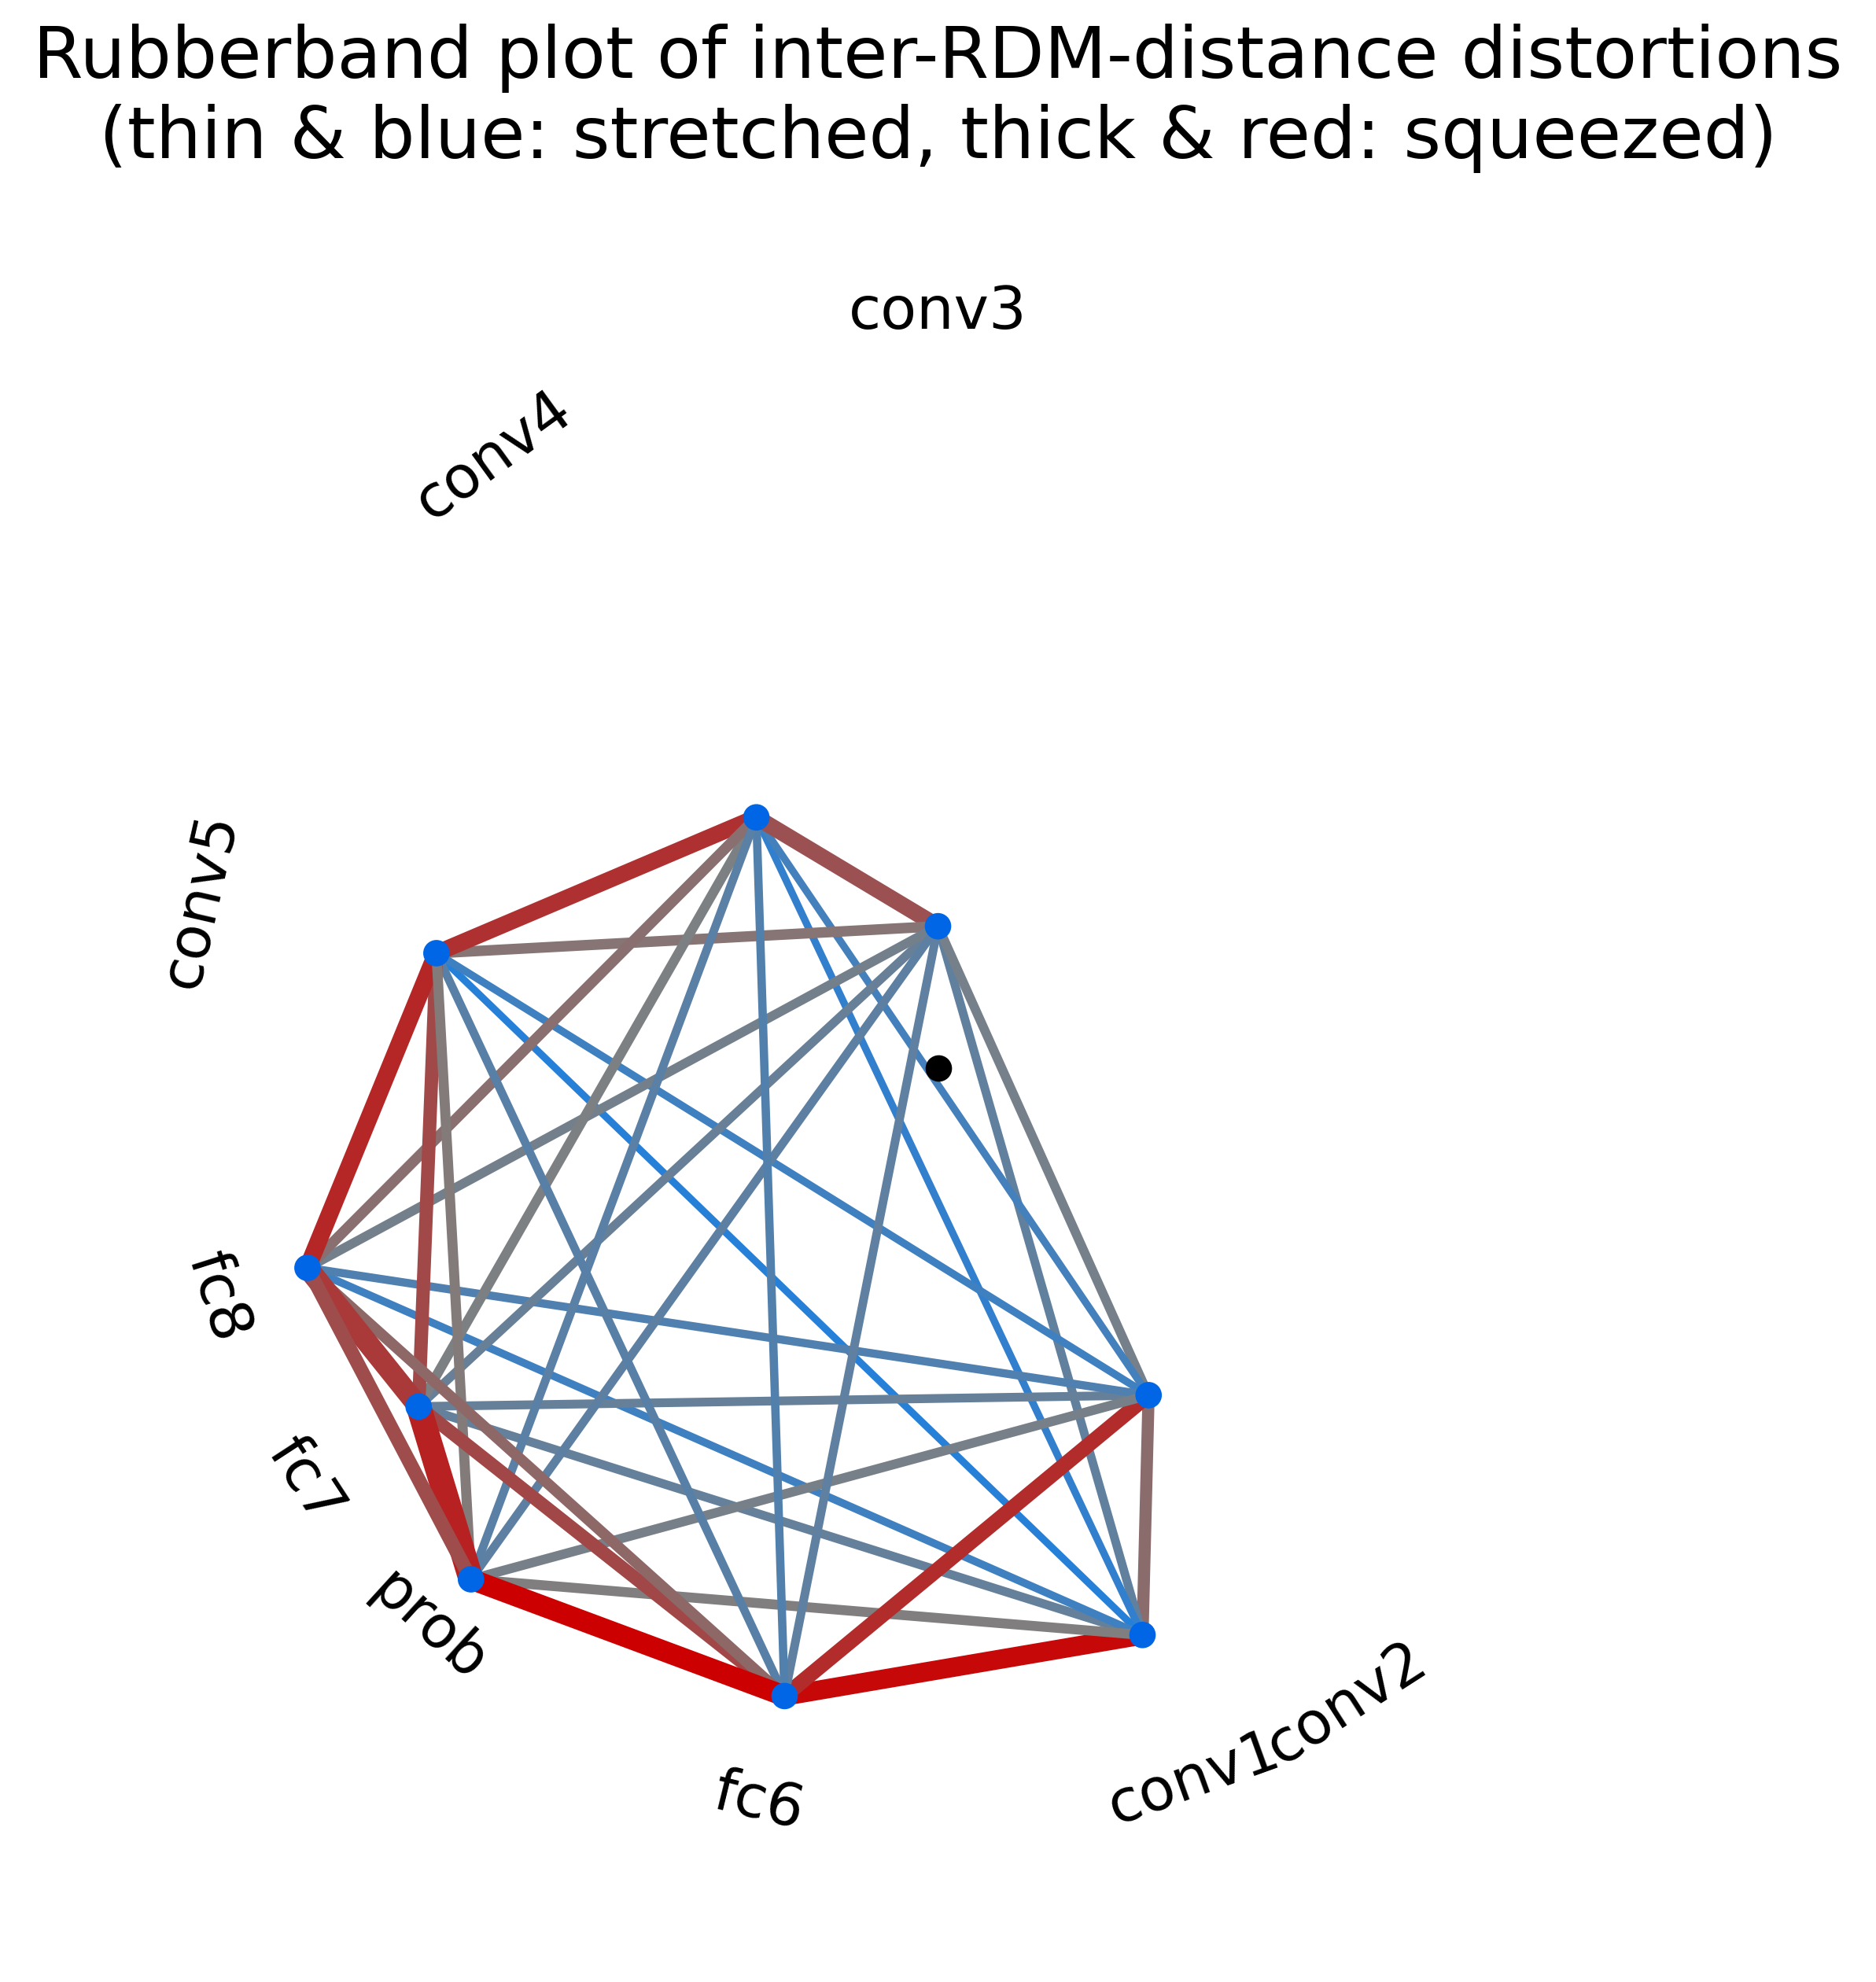

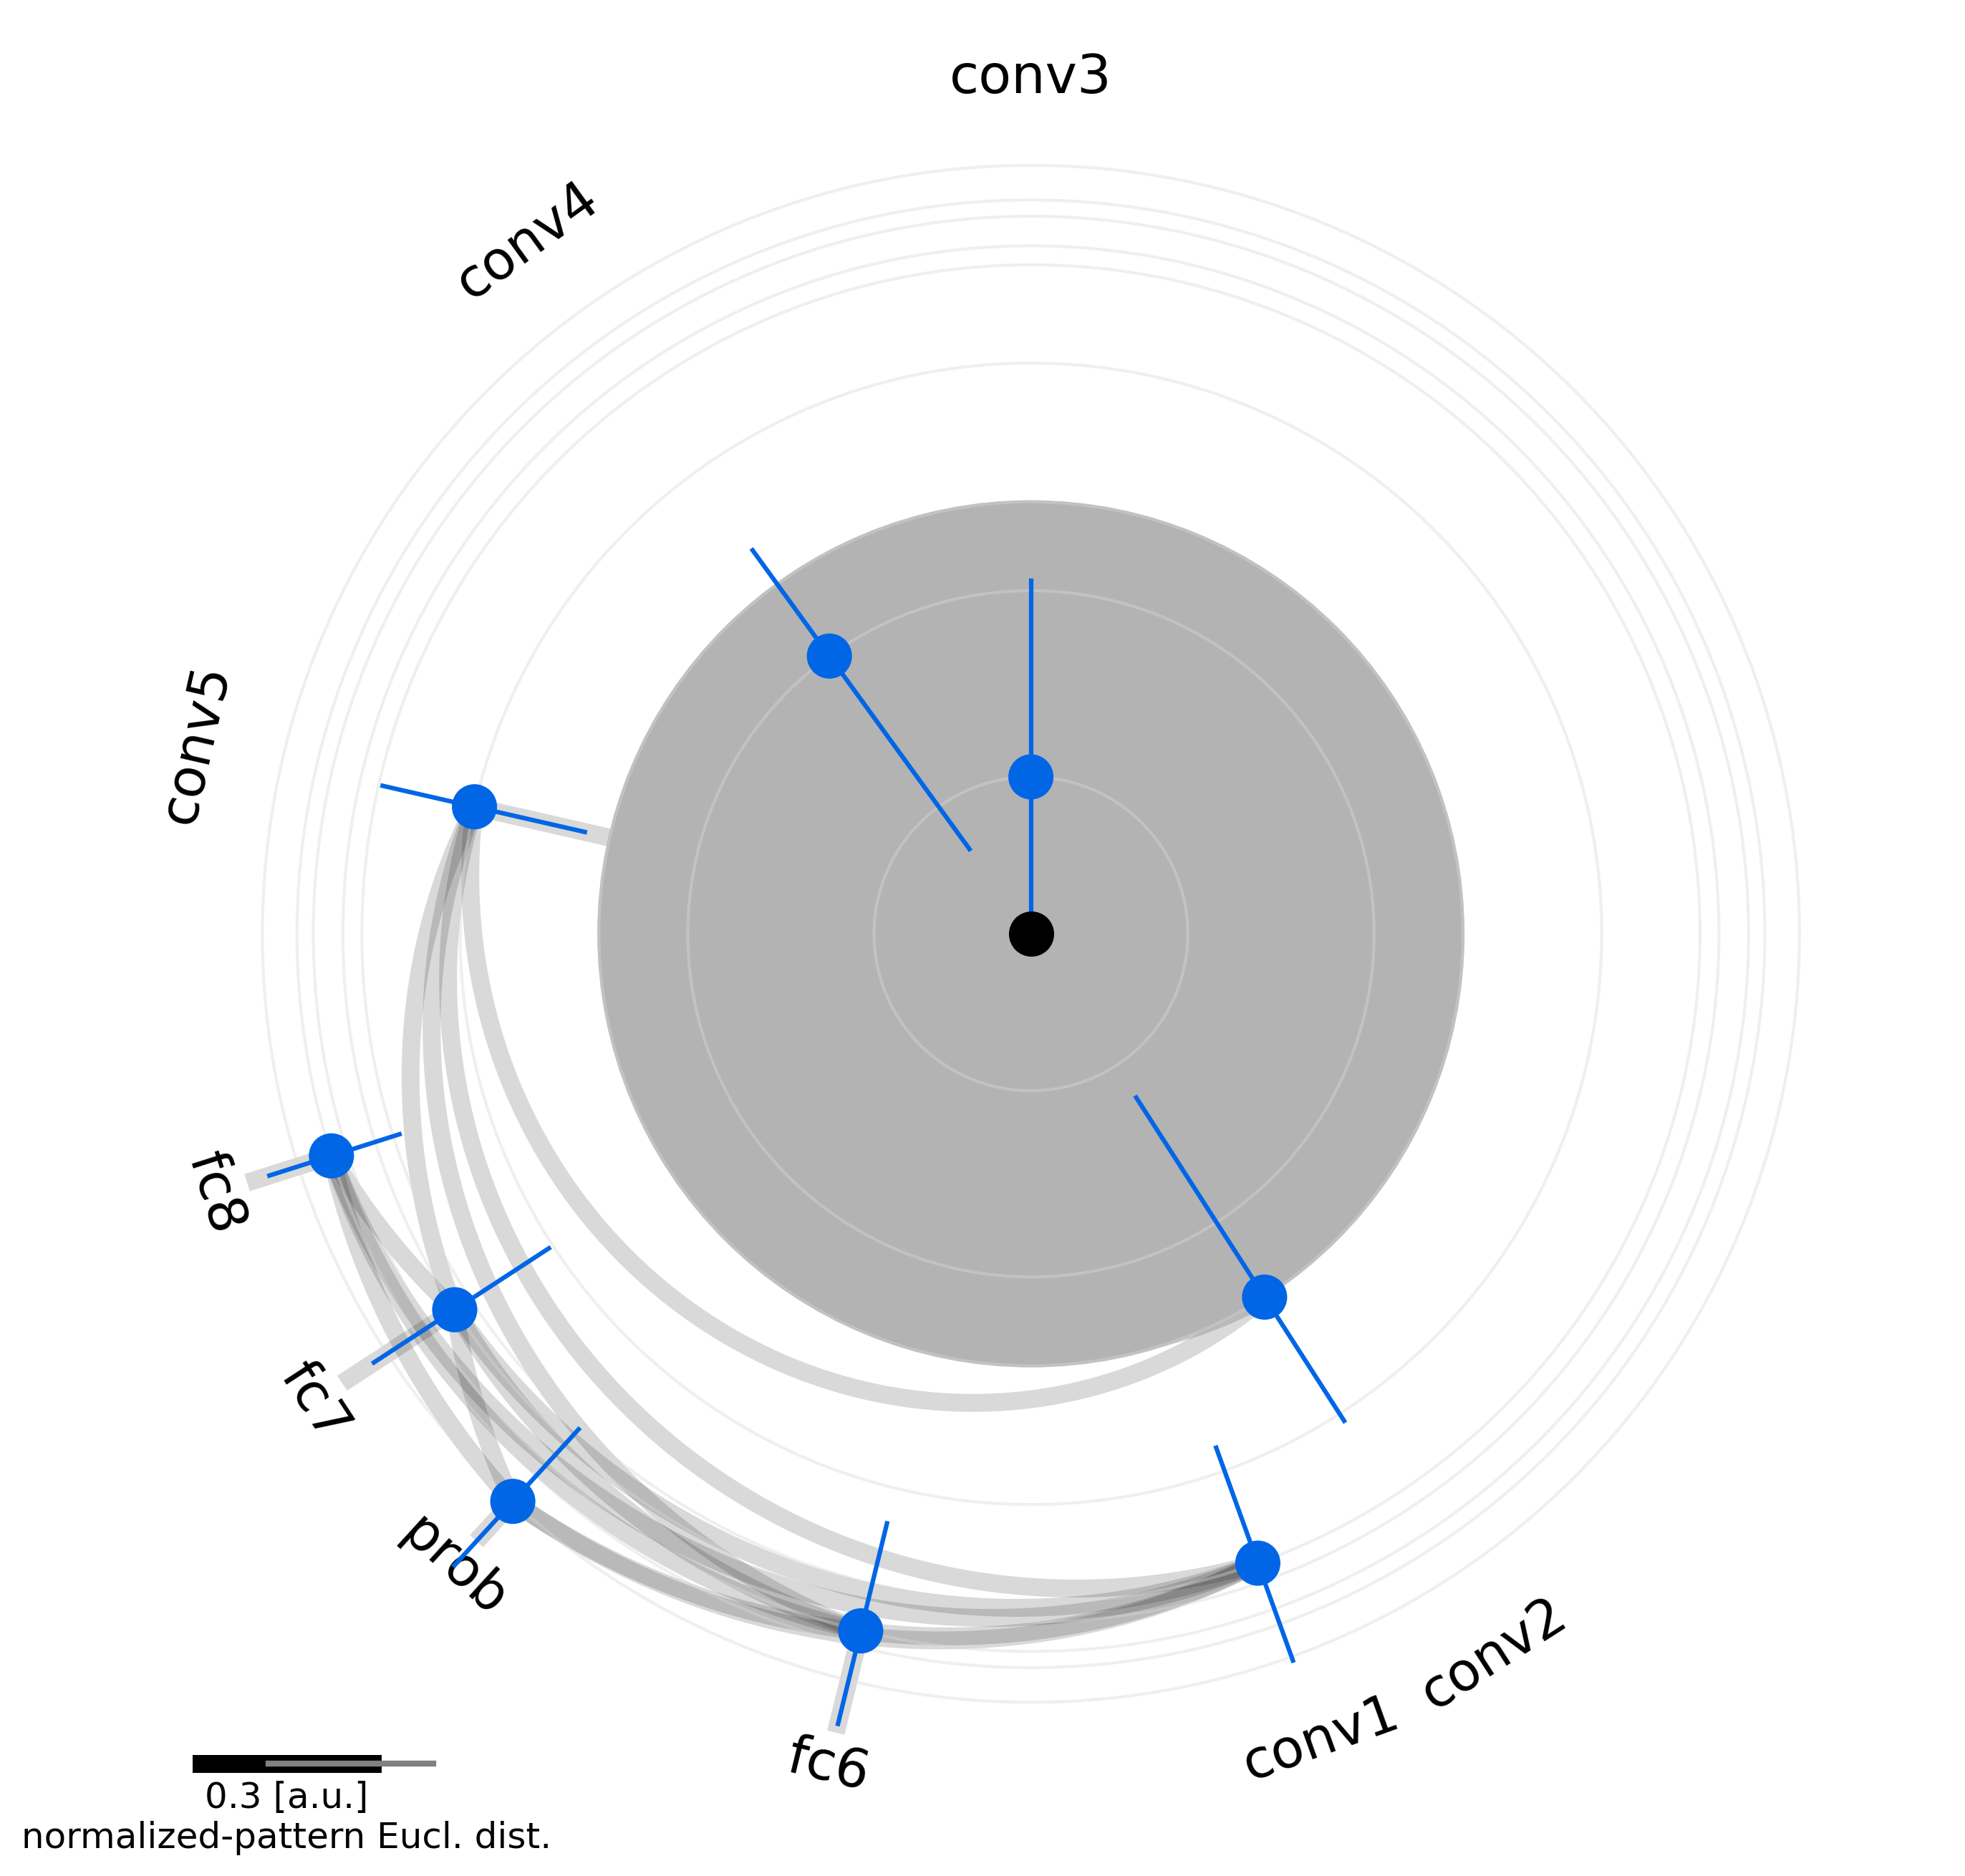

In [6]:
# plot results
rsatoolbox.vis.map_model_comparison(
    results_3_full, rdms_data=rdms_data)